In [2]:
%load_ext autoreload
%matplotlib inline
#%load_ext nb_black

In [3]:
import helpfunction as helper
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as patches
from matplotlib import colors
from matplotlib.colors import LogNorm
import scipy as scipy
from scipy.stats import norm
import time
import os

pd.set_option("display.max_columns", 50)

In [4]:
#%autoreload
os.getcwd()

'/home/pzhelnin/NuCCanalyser/mcc9-reco'

In [5]:
gr = (1 + 5 ** 0.5) / 2
rgb_c2 = np.array([44, 160, 44]) / 255

# Rename input files to ./input/run1/X_run1.root, where X is 'nu', 'on', 'off', and 'dirt'

outdir = "./output/dataMC/"
inputdir = "./input/run1/"
main_tree_name = "NuCCanalyzer"
#dict_names = ["nue", "nu", "on", "off", "dirt"]"off", "dirt"]
dict_names = ["nu", "on","off","dirt"]

In [6]:
fidvol_vtx = [24.8, 31.55, 32.47, 32, 26.9, 30]

mass_mu = 0.106
mass_p = 0.938272
kin_min = 0.04
kin_min_mu = kin_min + mass_mu

In [93]:
muon_candidate_selection = "track_score>0.90 &\
                            vtx_distance<4.0 &\
                            track_chi2_proton>60.0 &\
                            track_chi2_muon<30.0 &\
                            (track_chi2_proton/track_chi2_muon)>7.0 &\
                            generation==2 &\
                            track_length>100"

#track_length > 100 is from Giuseppe, used to be >20 

event_selection = "nu_pdg==14 &\
                   nu_contained &\
                   daughters_start_contained &\
                   longest_muon_candidate_length==track_length &\
                   nu_score>0.4"

joel_selection = "track_score>0.90 &\
                  vtx_distance<4.0 &\
                  track_chi2_proton>60.0 &\
                  track_chi2_muon<30.0 &\
                  (track_chi2_proton/track_chi2_muon)>7.0 &\
                  daughters_start_contained &\
                  nu_score>0.4&\
                  track_length>100" 

muon_candidate_selection = joel_selection 

GIUSUEPPE_CUTS = "tk_nhits>30 &\
                  tk1_nhits>10 &\
                  tk2_nhits>10 &\
                  tk_contain == 0 &\
                  vx_ntks>2 &\
                  track_score>0.90 &\
                  vtx_distance<4.0 &\
                  track_chi2_proton>60.0 &\
                  track_chi2_muon<30.0"



# for joel_selection also needs track contained cut 
# daughters_start_contained &\

### Load data:

In [94]:
d = {}
tree_names = [""]

flist = os.listdir(inputdir)

for sample in dict_names:
    file_name = ""
    for fn in flist:
        if sample + "_" in fn:
            file_name = fn
    file = uproot.open(inputdir + file_name)[main_tree_name]
    d[sample] = {}
    d[sample]["subruns"] = file["subruns"]
    d[sample]["events"] = file["Event"]
    d[sample]["daughters"] = file["Daughters"]

    # Flatten vectors into fields
    keys = list(map(lambda x: x.decode('utf-8'), d[sample]["daughters"].keys()))
    use_strk = 'strk_mid_gpar' in keys
    
    if use_strk:
        n = len(d[sample]["daughters"])

        def expand_gpar(field_name):
            keys.remove(field_name)
            data_rect = np.zeros(shape=(n,6), dtype=np.float32)
            data = d[sample]["daughters"].array(field_name)
            for i in range(len(data)):
                data_rect[i:i + 1, 0:len(data[i])] = data[i]
            suffix = ['vx', 'vy', 'vz', 'px', 'py', 'pz']
            fields = ['%s_%s' % (field_name, s) for s in suffix]
            return fields, data_rect.T

        mid_gpar_fields, mid_gpar_data = expand_gpar('strk_mid_gpar')
        tk1_gpar_fields, tk1_gpar_data = expand_gpar('strk_tk1_gpar')
        tk2_gpar_fields, tk2_gpar_data = expand_gpar('strk_tk2_gpar')

    all_events = d[sample]["events"].numentries
    sel_events = sum(d[sample]["events"].array("nu_mu_cc_selected"))
    print(sample + ":\tAll events: ", all_events)
    print(
        "\tSelected events: ",
        sel_events,
        "({:.02f}%)".format(sel_events*1.0 / all_events * 100),
    )

    d[sample]["event_hash"] = helper.eventHash(
        d[sample]["events"].pandas.df(["evt_time_sec", "evt_time_nsec"])
    )
    d[sample]["forbidden_hashes"] = d[sample]["event_hash"][
        d[sample]["event_hash"].duplicated()
    ]
    print("\tDuplicated:", len(d[sample]["forbidden_hashes"]))

    d[sample]["df_daughters"] = d[sample]["daughters"].pandas.df(keys, flatten=False)

    if use_strk:
        for x, y in zip(*(mid_gpar_fields, mid_gpar_data)):
            d[sample]["df_daughters"][x] = y.T
        for x, y in zip(*(tk1_gpar_fields, tk1_gpar_data)):
            d[sample]["df_daughters"][x] = y.T
        for x, y in zip(*(tk2_gpar_fields, tk2_gpar_data)):
            d[sample]["df_daughters"][x] = y.T

    d[sample]["df_daughters"]["hash"] = helper.eventHash(
        d[sample]["df_daughters"][["evt_time_sec", "evt_time_nsec"]]
    )
    d[sample]["df_daughters"]["duplicated"] = d[sample]["df_daughters"]["hash"].isin(
        d[sample]["forbidden_hashes"]
    )
    d[sample]["df_daughters"] = (
        d[sample]["df_daughters"].query("~duplicated").copy().reset_index(drop=True)
    )

('nu:\tAll events: ', 82000)
('\tSelected events: ', 12080, '(14.73%)')
('\tDuplicated:', 0)
('on:\tAll events: ', 27071)
('\tSelected events: ', 27071, '(100.00%)')
('\tDuplicated:', 0)
('off:\tAll events: ', 4716)
('\tSelected events: ', 4716, '(100.00%)')
('\tDuplicated:', 0)
('dirt:\tAll events: ', 207426)
('\tSelected events: ', 3789, '(1.83%)')
('\tDuplicated:', 103301)


### POT

In [95]:
# Data:
if True:
    samples = ["on", "off"]
    for sample in samples:
        out_name = inputdir + "pot/run_subrun_" + sample + ".txt"
        print(out_name)
        run_subrun = np.array(
            d[sample]["subruns"].arrays(["run", "subRun"], outputtype=pd.DataFrame)
        )
        np.savetxt(out_name, run_subrun, fmt="%d")

pot_on = 1.467e20
triggers_on = 35425849
triggers_off = 31725245

d["on"]["scale"] = 1
d["off"]["scale"] = triggers_on / triggers_off
title_str = "MicroBooNE {0:.2g} POT, INTERNAL".format(pot_on)
title_mc_str = r"$\nu_\mu$ CC Filter, MicroBooNE INTERNAL"

./input/run1/pot/run_subrun_on.txt
./input/run1/pot/run_subrun_off.txt


In [96]:
# MC
samples_mc = ["nue","nu", "dirt"]
for smc in samples_mc:
    if smc in dict_names:
        pot = sum(d[smc]["subruns"].array("pot"))
        pot_corr = pot * (
            1 - len(d[smc]["forbidden_hashes"]) * 2 / d[smc]["events"].numentries
        )
        d[smc]["scale"] = pot_on / pot_corr
        print(smc, ":\t", pot_corr)

('nu', ':\t', 1.0230004542766108e+20)
('dirt', ':\t', 6.417133149580343e+20)


### Add fields to daughters: MC

- Fidvol: 10cm everywhere, 50 cm on z end
- abs(pdgcode)=14 and charged current
- min kin E of the muon, 40MeV
- for pi0 channel: exactly one daughter is a pi0
- also split up using the interaxtion type

In [97]:
# Add the signal categories, only needed for the nu sample:
cols = [
    "mc_nu_ccnc",
    "mc_nu_lepton_energy",
    "mc_nu_pdg",
    "mc_nu_vx",
    "mc_nu_vy",
    "mc_nu_vz",
]

df_nu_event = d["nu"]["events"].pandas.df(cols)

nu_tpc_mask = helper.inTPC_mask(df_nu_event, "mc_nu_vx", "mc_nu_vy", "mc_nu_vz")

nu_fid_vol_mask = helper.inTPC_mask(
    df_nu_event, "mc_nu_vx", "mc_nu_vy", "mc_nu_vz", fidvol=fidvol_vtx
)

sig_def_ccinc = "abs(mc_nu_pdg)==14 & mc_nu_ccnc==0 & mc_nu_lepton_energy>@kin_min_mu"
sig_mask_ccinc = df_nu_event.eval(sig_def_ccinc) & nu_fid_vol_mask

# Has the event one pi0
pi0_index = d["nu"]["events"].array("mc_nu_daughter_pdg") == 111
sig_mask_pi0 = sig_mask_ccinc & (pi0_index.sum() == 1)

# Has x protons
sig_masks_proton = []
m1 = d["nu"]["events"].array("mc_nu_daughter_pdg") == 2212
m2 = d["nu"]["events"].array("mc_nu_daughter_energy") > mass_p + kin_min
proton_index = m1 & m2
sig_masks_proton = [
    sig_mask_ccinc & (proton_index.sum() == x_proton) for x_proton in range(4)
]


# Add MC info
mapper = dict(zip(d["nu"]["event_hash"], nu_tpc_mask))
d["nu"]["df_daughters"]["mc_nu_in_tpc"] = d["nu"]["df_daughters"]["hash"].map(mapper)
mapper = dict(zip(d["nu"]["event_hash"], nu_fid_vol_mask))
d["nu"]["df_daughters"]["mc_nu_fid_vol"] = d["nu"]["df_daughters"]["hash"].map(mapper)

mapper = dict(zip(d["nu"]["event_hash"], sig_mask_ccinc))
d["nu"]["df_daughters"]["mc_sig_nuccinc"] = d["nu"]["df_daughters"]["hash"].map(mapper)
mapper = dict(zip(d["nu"]["event_hash"], sig_mask_pi0))
d["nu"]["df_daughters"]["mc_sig_nuccpi0"] = d["nu"]["df_daughters"]["hash"].map(mapper)

In [98]:
mapper_list = [
    "mc_nu_energy",
    "mc_nu_pdg",
    "mc_nu_ccnc",
    "mc_nu_lepton_theta",
    "mc_nu_vtx_distance",
    "clustered_hit_completeness",
    "matched_hit_fraction",
]

for smc in samples_mc:
    if smc in dict_names:
        print(smc)
        for field in mapper_list:
            mapper = dict(zip(d[smc]["event_hash"], d[smc]["events"].array(field)))
            d[smc]["df_daughters"][field] = d[smc]["df_daughters"]["hash"].map(mapper)

nu
dirt


### Add fields to daughters: All samples

In [99]:
mapper_list = [
    "nu_pdg",
    "num_tracks",
    "num_showers",
    "obvious_cosmic_chi2",
    "nu_flash_chi2",
    "nu_score",
    "nu_contained",
    "daughters_start_contained",
    "event_weight",
]

for sample in dict_names:
    print(sample)
    #if sample in samples_mc:
    #    maplist = mapper_list + ['v1xpos','v2xpos','v1ypos','v2ypos','v1zpos','v2zpos']
    #else:
    #    maplist = mapper_list

    for field in mapper_list:
        mapper = dict(zip(d[sample]["event_hash"], d[sample]["events"].array(field)))
        d[sample]["df_daughters"][field] = d[sample]["df_daughters"]["hash"].map(mapper)

        d[sample]["df_daughters"][["theta_beam", "phi_beam"]] = helper.cosmic_angles(
            *d[sample]["df_daughters"][
                ["track_dirx", "track_diry", "track_dirz"]
            ].T.values
        )

        end_mask = helper.inTPC_mask(
            d[sample]["df_daughters"],
            "track_endx",
            "track_endy",
            "track_endz",
            [10] * 6,
        )
        d[sample]["df_daughters"]["contained"] = (
            d[sample]["df_daughters"]["start_contained"] & end_mask
        )

nu
on
off
dirt


## Selection

In [100]:
# Selection queries
query_select_wo_trackcut = event_selection
query_select = query_select_wo_trackcut + " & track_length>100.0"
query_pure = "mc_nu_vtx_distance<5 & abs(mc_pdg)==13"
query_event = query_select + " & " + query_pure

In [101]:
for sample in dict_names:
    # Tag the muon candidate
    d[sample]["df_daughters"]["muon_candidate"] = d[sample]["df_daughters"].eval(
        muon_candidate_selection
    )
    d[sample]["df_daughters"].loc[
        d[sample]["df_daughters"]["muon_candidate"], "longest_muon_candidate_length"
    ] = (
        d[sample]["df_daughters"]
        .query("muon_candidate")
        .groupby(["hash"])["track_length"]
        .transform(max)
    )
    d[sample]["df_daughters"].loc[
        ~d[sample]["df_daughters"]["muon_candidate"], "longest_muon_candidate_length"
    ] = -1

    d[sample]["df_daughters"]["chi2_ratio"] = d[sample]["df_daughters"].eval(
        "track_chi2_proton/track_chi2_muon"
    )
    d[sample]["df_daughters"].loc[
        d[sample]["df_daughters"]["muon_candidate"], "highest_chi2_ratio"
    ] = (
        d[sample]["df_daughters"]
        .query("muon_candidate")
        .groupby(["hash"])["chi2_ratio"]
        .transform(max)
    )
    d[sample]["df_daughters"].loc[
        ~d[sample]["df_daughters"]["muon_candidate"], "highest_chi2_ratio"
    ] = -1

    # Tag the event selection
    if sample == "dirt" or sample == "off": continue 
    d[sample]["df_daughters"]["python_select"] = d[sample]["df_daughters"].eval(
        query_select
    )

In [102]:
# How much muon candidates per event?
grouped = (
    d["nu"]["df_daughters"]
    .query("mc_sig_nuccinc")[["hash", "muon_candidate"]]
    .groupby("hash")
)
grouped.sum()["muon_candidate"].value_counts() / len(grouped)

0.0    0.612577
1.0    0.382025
2.0    0.005398
Name: muon_candidate, dtype: float64

## Efficiency/Purity

In [53]:
# Using python:
num_sel = d["nu"]["df_daughters"].query("mc_sig_nuccinc")["python_select"].sum()
num_denom = sum(sig_mask_ccinc)
error = helper.effErr(num_sel, num_denom)
print(
    "Muon neutrino CC inc selection efficiency: ({0:0.2f}+-{1:0.2f})%".format(
        num_sel / num_denom * 100, error * 100
    )
)

num_sel = d["nu"]["df_daughters"].query("mc_sig_nuccpi0")["python_select"].sum()
num_denom = sum(sig_mask_pi0)
error = helper.effErr(num_sel, num_denom)
print(
    "Muon neutrino CC pi0 selection efficiency: ({0:0.2f}+-{1:0.2f})%".format(
        num_sel / num_denom * 100, error * 100
    )
)
# purity
purity_nom = (
    d["nu"]["df_daughters"].query("mc_sig_nuccinc").eval(query_select).sum()
    * d["nu"]["scale"]
)
purity_nom_plus = (
    d["nu"]["df_daughters"].query("mc_sig_nuccinc").eval(query_event).sum()
    * d["nu"]["scale"]
)
purity_denom = 0

for s in ["off", "nu"]: #, "dirt"]:
    purity_denom += d[s]["df_daughters"]["python_select"].sum() * d[s]["scale"]

error = helper.effErr(purity_nom, purity_denom)
purity = purity_nom / purity_denom
print(
    "Muon neutrino CC inc selection purity (basic): ({0:0.2f}+-{1:0.2f})%".format(
        purity * 100, error * 100
    )
)
error = helper.effErr(purity_nom_plus, purity_denom)
purity_plus = purity_nom_plus / purity_denom
print(
    "Muon neutrino CC inc selection purity (strict): ({0:0.2f}+-{1:0.2f})%".format(
        purity_plus * 100, error * 100
    )
)

Muon neutrino CC inc selection efficiency: (200.00+-nan)%
Muon neutrino CC pi0 selection efficiency: (200.00+-nan)%
Muon neutrino CC inc selection purity (basic): (65.23+-0.17)%
Muon neutrino CC inc selection purity (strict): (57.35+-0.18)%


helpfunction.py:34: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(teller*(1-teller/noemer))/noemer


In [38]:
# Using C++ analyser:
num_sel = d["nu"]["events"].array("nu_mu_cc_selected")[sig_mask_ccinc].sum()
num_denom = sum(sig_mask_ccinc)
error = helper.effErr(num_sel, num_denom)
eff = num_sel / num_denom
print(
    "Muon neutrino CC inc selection efficiency: ({0:0.2f}+-{1:0.2f})%".format(
        num_sel / num_denom * 100, error * 100
    )
)

num_sel = d["nu"]["events"].array("nu_mu_cc_selected")[sig_mask_pi0].sum()
num_denom = sum(sig_mask_pi0)
error = helper.effErr(num_sel, num_denom)
print(
    "Muon neutrino CC pi0 selection efficiency: ({0:0.2f}+-{1:0.2f})%".format(
        num_sel / num_denom * 100, error * 100
    )
)

purity_nom = (
    d["nu"]["events"].array("nu_mu_cc_selected")[sig_mask_ccinc].sum()
    * d["nu"]["scale"]
)
purity_denom = 0

for s in ["off", "nu"]: #, "dirt"]:
    purity_denom += d[s]["events"].array("nu_mu_cc_selected").sum() * d[s]["scale"]

error = helper.effErr(purity_nom, purity_denom)
purity = purity_nom / purity_denom
print(
    "Muon neutrino CC inc selection purity (basic): ({0:0.2f}+-{1:0.2f})%".format(
        purity * 100, error * 100
    )
)

Muon neutrino CC inc selection efficiency: (0.00+-0.18)%
Muon neutrino CC pi0 selection efficiency: (0.00+-0.47)%
Muon neutrino CC inc selection purity (basic): (48.27+-0.34)%


In [54]:
# What is the quality of the selected signal event:
d["nu"]["df_daughters"].query("mc_sig_nuccinc & python_select")[
    "mc_pdg"
].abs().value_counts() / len(
    d["nu"]["df_daughters"].query("mc_sig_nuccinc & python_select")
)

13      0.945364
211     0.031043
2212    0.017798
2112    0.005381
22      0.000414
Name: mc_pdg, dtype: float64

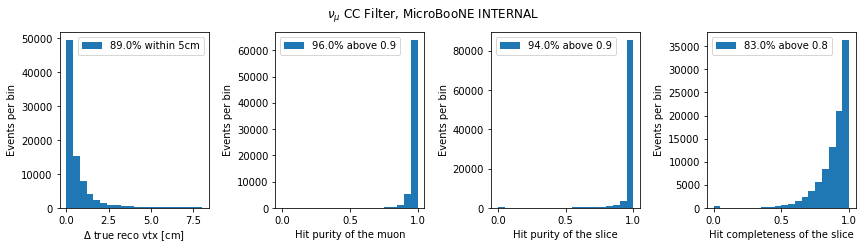

In [132]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(7.5 * gr, 3.5))

sig_selected_mask = d["nu"]["events"].array("nu_mu_cc_selected") & sig_mask_ccinc
distances = d["nu"]["events"].array("mc_nu_vtx_distance")[sig_selected_mask]

ax[0].hist(
    distances,
    range=(0, 8),
    bins=20,
    label="{0:0.1f}% within 5cm".format(sum(distances < 5) * 100 / len(distances)),
)
ax[0].set_xlabel(r"$\Delta$ true reco vtx [cm]")
ax[0].set_ylabel("Events per bin")
ax[0].legend()

hit_fraq = d["nu"]["df_daughters"].query(
    "python_select & mc_sig_nuccinc & abs(mc_pdg)==13"
)["mc_hit_fraction"]

ax[1].hist(
    hit_fraq,
    range=(0, 1),
    bins=20,
    label="{0:0.1f}% above 0.9".format(sum(hit_fraq > 0.9) * 100 / len(hit_fraq)),
)
ax[1].set_xlabel(r"Hit purity of the muon")
ax[1].set_ylabel("Events per bin")
ax[1].legend()

slice_purity = d["nu"]["events"].array("matched_hit_fraction")[sig_selected_mask]
slice_completeness = d["nu"]["events"].array("clustered_hit_completeness")[
    sig_selected_mask
]

ax[2].hist(
    slice_purity,
    range=(0, 1),
    bins=20,
    label="{0:0.1f}% above 0.9".format(
        sum(slice_purity > 0.9) * 100 / len(slice_purity)
    ),
)
ax[2].set_xlabel(r"Hit purity of the slice")
ax[2].set_ylabel("Events per bin")
ax[2].legend()

ax[3].hist(
    slice_completeness,
    range=(0, 1),
    bins=20,
    label="{0:0.1f}% above 0.8".format(
        sum(slice_completeness > 0.8) * 100 / len(slice_completeness)
    ),
)
ax[3].set_xlabel(r"Hit completeness of the slice")
ax[3].set_ylabel("Events per bin")
ax[3].legend()

fig.suptitle(title_mc_str)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
#fig.savefig(outdir + "muon_quality.pdf")

In [133]:
# Fidvol ratio vs MCC8 analysis:
fv1 = 1
for i in range(3):
    fv1 *= (helper.upper[i] - fidvol_vtx[2 * i]) - (
        helper.lower[i] + fidvol_vtx[2 * i + 1]
    )
    print(helper.upper[i] - fidvol_vtx[2 * i])
    print(helper.lower[i] + fidvol_vtx[2 * i + 1])
print(fv1)


fv2 = (233 - 70) * (256.35 - 24) * (1036.8 - 25 - 100 - 85)
fv1 / fv2

230.0
30.0
85.0
-83.53
1010.0
30.1
33028509.4


1.0547711073514345

## Plots

### Muon PID plots

In [134]:
def mc_track_contained(x_s, y_s, z_s, p_x, p_y, p_z, length):
    l_n = length / np.sqrt(p_x ** 2 + p_y ** 2 + p_z ** 2)
    x_e = x_s + p_x * l_n
    y_e = y_s + p_y * l_n
    z_e = z_s + p_z * l_n
    df_end = pd.DataFrame({"x_e": x_e, "y_e": y_e, "z_e": z_e})
    return helper.inTPC_mask(
        df_end, "x_e", "y_e", "z_e", fidvol=[10, 10, 10, 10, 10, 10]
    )


a = d["nu"]["daughters"].pandas.df(
    ["mc_vx", "mc_vy", "mc_vz", "mc_px", "mc_py", "mc_pz", "mc_length"]
)
nu_daughters_contained = mc_track_contained(*a.values.T)

IOError: [Errno 2] No such file or directory: './output/dataMC/momentum_comparison.pdf'

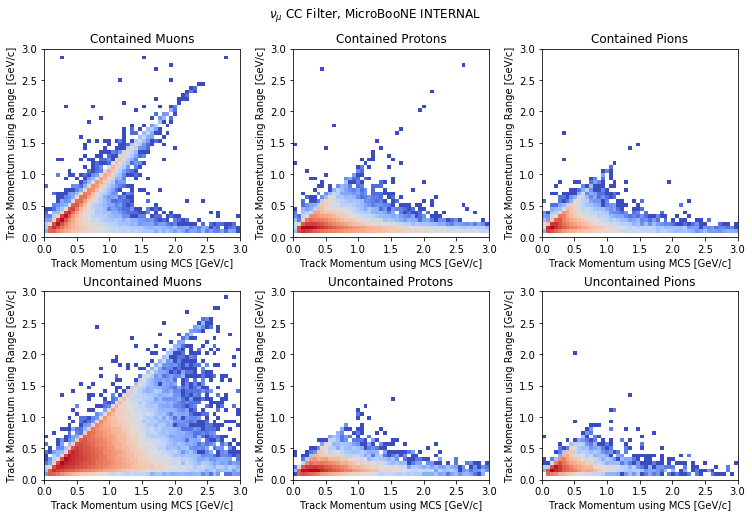

In [135]:
neutrino = (
    (d["nu"]["daughters"].array("mc_hit_fraction") > 0.5)
    & (d["nu"]["daughters"].array("track_length") > 5)
    & d["nu"]["daughters"].array("start_contained")
)

muons = (d["nu"]["daughters"].array("mc_pdg") == 13) & neutrino & nu_daughters_contained
protons = (
    (d["nu"]["daughters"].array("mc_pdg") == 2212) & neutrino & nu_daughters_contained
)
pions = (
    (d["nu"]["daughters"].array("mc_pdg") == 211) & neutrino & nu_daughters_contained
)
un_muons = (
    (d["nu"]["daughters"].array("mc_pdg") == 13) & neutrino & ~nu_daughters_contained
)
un_protons = (
    (d["nu"]["daughters"].array("mc_pdg") == 2212) & neutrino & ~nu_daughters_contained
)
un_pions = (
    (d["nu"]["daughters"].array("mc_pdg") == 211) & neutrino & ~nu_daughters_contained
)

data8 = [
    d["nu"]["daughters"].array("track_range_mom_mu")[muons],
    d["nu"]["daughters"].array("track_range_mom_mu")[protons],
    d["nu"]["daughters"].array("track_range_mom_mu")[pions],
    d["nu"]["daughters"].array("track_range_mom_mu")[un_muons],
    d["nu"]["daughters"].array("track_range_mom_mu")[un_protons],
    d["nu"]["daughters"].array("track_range_mom_mu")[un_pions],
]

data9 = [
    d["nu"]["daughters"].array("track_mcs_mom")[muons],
    d["nu"]["daughters"].array("track_mcs_mom")[protons],
    d["nu"]["daughters"].array("track_mcs_mom")[pions],
    d["nu"]["daughters"].array("track_mcs_mom")[un_muons],
    d["nu"]["daughters"].array("track_mcs_mom")[un_protons],
    d["nu"]["daughters"].array("track_mcs_mom")[un_pions],
]


fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(6.5 * gr, 7.3))
ax = ax.flatten()
for i, l in enumerate(
    [
        "Contained Muons",
        "Contained Protons",
        "Contained Pions",
        "Uncontained Muons",
        "Uncontained Protons",
        "Uncontained Pions",
    ]
):
    ax[i].hist2d(
        data9[i],
        data8[i],
        bins=50,
        range=((0, 3), (0, 3)),
        cmap="coolwarm",
        norm=LogNorm(),
    )
    ax[i].set_xlabel("Track Momentum using MCS [GeV/c]")
    ax[i].set_ylabel("Track Momentum using Range [GeV/c]")
    ax[i].set_title(l)

fig.suptitle(title_mc_str)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig(outdir + "momentum_comparison.pdf")

Pseudo-exiting tracks, MCS momentum

In [ ]:
neutrino = (
    (d["nu"]["daughters"].array("mc_hit_fraction") > 0.5)
    & (d["nu"]["daughters"].array("track_length") > 5)
    & d["nu"]["daughters"].array("start_contained")
)

muons = (d["nu"]["daughters"].array("mc_pdg") == 13) & neutrino & nu_daughters_contained
protons = (
    (d["nu"]["daughters"].array("mc_pdg") == 2212) & neutrino & nu_daughters_contained
)
pions = (
    (d["nu"]["daughters"].array("mc_pdg") == 211) & neutrino & nu_daughters_contained
)
un_muons = (
    (d["nu"]["daughters"].array("mc_pdg") == 13) & neutrino & ~nu_daughters_contained
)
un_protons = (
    (d["nu"]["daughters"].array("mc_pdg") == 2212) & neutrino & ~nu_daughters_contained
)
un_pions = (
    (d["nu"]["daughters"].array("mc_pdg") == 211) & neutrino & ~nu_daughters_contained
)

data8 = [
    d["nu"]["daughters"].array("track_range_mom_mu")[muons],
    d["nu"]["daughters"].array("track_range_mom_mu")[protons],
    d["nu"]["daughters"].array("track_range_mom_mu")[pions],
    d["nu"]["daughters"].array("track_range_mom_mu")[un_muons],
    d["nu"]["daughters"].array("track_range_mom_mu")[un_protons],
    d["nu"]["daughters"].array("track_range_mom_mu")[un_pions],
]

data9 = [
    d["nu"]["daughters"].array("track_mcs_mom")[muons],
    d["nu"]["daughters"].array("track_mcs_mom")[protons],
    d["nu"]["daughters"].array("track_mcs_mom")[pions],
    d["nu"]["daughters"].array("track_mcs_mom")[un_muons],
    d["nu"]["daughters"].array("track_mcs_mom")[un_protons],
    d["nu"]["daughters"].array("track_mcs_mom")[un_pions],
]


fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(6.5 * gr, 7.3))
ax = ax.flatten()
for i, l in enumerate(
    [
        "Contained Muons",
        "Contained Protons",
        "Contained Pions",
        "Uncontained Muons",
        "Uncontained Protons",
        "Uncontained Pions",
    ]
):
    ax[i].hist2d(
        data9[i],
        data8[i],
        bins=50,
        range=((0, 3), (0, 3)),
        cmap="coolwarm",
        norm=LogNorm(),
    )
    ax[i].set_xlabel("Track Momentum using MCS [GeV/c]")
    ax[i].set_ylabel("Track Momentum using Range [GeV/c]")
    ax[i].set_title(l)

fig.suptitle(title_mc_str)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig(outdir + "momentum_comparison.pdf")

In [ ]:
neutrino = (d["nu"]["daughters"].array("mc_hit_fraction") > 0.5) & (
    d["nu"]["daughters"].array("track_length") > 5
)
muons = (d["nu"]["daughters"].array("mc_pdg") == 13) & neutrino
protons = (d["nu"]["daughters"].array("mc_pdg") == 2212) & neutrino
pions = (abs(d["nu"]["daughters"].array("mc_pdg")) == 211) & neutrino

neutrino = (d["nu"]["daughters"].array("mc_hit_fraction") > 0.5) & (
    d["nu"]["daughters"].array("track_length") > 5
)
electrons = (d["nu"]["daughters"].array("mc_pdg") == 11) & neutrino

step1_nu = (
    (d["nu"]["daughters"].array("track_length") > 20)
    & (d["nu"]["daughters"].array("track_score") > 0.85)
    & (d["nu"]["daughters"].array("vtx_distance") < 4)
)
step1_nue = (
    (d["nu"]["daughters"].array("track_length") > 20)
    & (d["nu"]["daughters"].array("track_score") > 0.85)
    & (d["nu"]["daughters"].array("vtx_distance") < 4
    & (d["nu"]["daughters"].array("mc_pdg") == 11))
)


data1 = [
    d["nu"]["daughters"].array("track_chi2_proton")[muons & step1_nu],
    d["nu"]["daughters"].array("track_chi2_proton")[protons & step1_nu],
    d["nu"]["daughters"].array("track_chi2_proton")[pions & step1_nu],
    d["nu"]["daughters"].array("track_chi2_proton")[electrons & step1_nue],
]
data2 = [
    d["nu"]["daughters"].array("track_chi2_muon")[muons & step1_nu],
    d["nu"]["daughters"].array("track_chi2_muon")[protons & step1_nu],
    d["nu"]["daughters"].array("track_chi2_muon")[pions & step1_nu],
    d["nu"]["daughters"].array("track_chi2_muon")[electrons & step1_nue],
]
data3 = [
    d["nu"]["daughters"].array("track_length")[muons],
    d["nu"]["daughters"].array("track_length")[protons],
    d["nu"]["daughters"].array("track_length")[pions],
    d["nu"]["daughters"].array("track_length")[electrons],
]
data4 = [
    d["nu"]["daughters"].array("track_score")[muons],
    d["nu"]["daughters"].array("track_score")[protons],
    d["nu"]["daughters"].array("track_score")[pions],
    d["nu"]["daughters"].array("track_score")[electrons],
]

data5 = [
    data1[0] / data2[0],
    data1[1] / data2[1],
    data1[2] / data2[2],
    data1[3] / data2[3],
]

data6 = [
    d["nu"]["daughters"].array("vtx_distance")[muons],
    d["nu"]["daughters"].array("vtx_distance")[protons],
    d["nu"]["daughters"].array("vtx_distance")[pions],
    d["nu"]["daughters"].array("vtx_distance")[electrons],
]

labs = [
    r"$\nu_\mu$ muons",
    r"$\nu_\mu$ protons",
    r"$\nu_\mu$ charged pions",
    r"$\nu_e$ electrons",
]

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(8.5 * gr, 3.5))
ax[1].hist(
    data1, label=labs, range=(0, 350), histtype="step", bins=35, lw=2, density=True
)
ax[1].set_xlim(0, 350)
ax[1].axvspan(60, 350, alpha=0.2, color="green")
ax[1].legend()
ax[1].set_xlabel(r"Proton $\chi^2$")
ax[1].set_title("Proton $\chi^2$")
ax[0].hist(
    data2, label=labs, range=(0, 60), histtype="step", bins=30, lw=2, density=True
)
ax[0].axvspan(0, 30, alpha=0.2, color="green")
ax[0].set_xlim(0, 60)
ax[0].legend()
ax[0].set_xlabel(r"Muon $\chi^2$")
ax[0].set_title("Muon $\chi^2$")
ax[2].hist(
    data5, label=labs, range=(0, 40), histtype="step", bins=40, lw=2, density=True
)
ax[2].set_xlim(0, 40)
ax[2].axvspan(7, 40, alpha=0.2, color="green")
ax[2].set_xlabel(r"Proton $\chi^2$ / Muon $\chi^2$")
ax[2].set_title(r"Proton $\chi^2$ / Muon $\chi^2$")
ax[2].set_yscale("log")
ax[2].set_ylim(1e-3, 1)
ax[2].legend()

ax[0].set_ylabel("Area Normalised")
ax[1].set_ylabel("Area Normalised")
ax[2].set_ylabel("Area Normalised")
fig.tight_layout()
fig.show()
fig.savefig(outdir + "muon_candidate1.pdf")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(6 * gr, 4))
ax[0].hist2d(
    data1[0],
    data2[0],
    bins=50,
    range=((0, 350), (0, 100)),
    cmap="coolwarm",
    norm=LogNorm(),
)
ax[0].fill_between(
    [60, 210, 350],
    [60 / 7, 30, 30],
    facecolor=(*rgb_c2, 0.33),
    edgecolor=(rgb_c2),
    lw=1.5,
)
ax[0].set_xlabel(r"Proton $\chi^2$")
ax[0].set_ylabel(r"Muon $\chi^2$")
ax[0].set_title("Muons", loc="left")
ax[0].set_title("MicroBooNE INTERNAL", loc="right")

ax[1].hist2d(
    data1[1],
    data2[1],
    bins=50,
    range=((0, 350), (0, 100)),
    cmap="coolwarm",
    norm=LogNorm(),
)
ax[1].fill_between(
    [60, 210, 350],
    [60 / 7, 30, 30],
    facecolor=(*rgb_c2, 0.33),
    edgecolor=(rgb_c2),
    lw=1.5,
)
ax[1].set_xlabel(r"Proton $\chi^2$")
ax[1].set_ylabel(r"Muon $\chi^2$")
ax[1].set_title("Protons", loc="left")
ax[1].set_title("MicroBooNE INTERNAL", loc="right")
fig.tight_layout()
fig.show()
fig.savefig(outdir + "muon_candidate2.pdf")


fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(8.5 * gr, 3.5))
ax[0].hist(
    data3, label=labs, range=(0, 200), histtype="step", bins=40, lw=2, density=True
)
ax[0].legend()
ax[0].set_xlabel(r"Track Length [cm]")
ax[0].axvspan(20, 200, alpha=0.2, color="green")
ax[0].set_title("Track Length")
ax[0].set_xlim(0, 200)

ax[1].hist(
    data4, label=labs, range=(0.5, 1), histtype="step", bins=25, lw=2, density=True
)
ax[1].axvspan(0.85, 1, alpha=0.2, color="green")
ax[1].set_yscale("log")
ax[1].set_xlim(0.5, 1)
ax[1].legend(loc=2)
ax[1].set_xlabel(r"Track Score")
ax[1].set_title("Track Score")
ax[2].hist(
    data6, label=labs, range=(0, 6), histtype="step", bins=30, lw=2, density=True
)
ax[2].set_xlim(0, 6)
ax[2].axvspan(0, 4, alpha=0.2, color="green")
ax[2].set_xlabel(r"Vertex Distance [cm]")
ax[2].set_title(r"Vertex Distance")
ax[2].set_yscale("log")
ax[2].legend()
ax[0].set_ylabel("Area Normalised")
ax[1].set_ylabel("Area Normalised")
ax[2].set_ylabel("Area Normalised")
fig.tight_layout()
fig.show()
fig.savefig(outdir + "muon_candidate3.pdf")

#### Efficiency plots

In [ ]:
def plot_panel_eff(ax, field, x_label, N_bins, x_min, x_max, legend=True):

    denom = d["nu"]["events"].array(field)[sig_mask_ccinc]
    sig_mask_sel = d["nu"]["events"].array("nu_mu_cc_selected") & sig_mask_ccinc
    nom = d["nu"]["events"].array(field)[sig_mask_sel]
    data = [denom, nom]
    edges, _, bins, _, _ = helper.histHelper(N_bins, x_min, x_max, data)
    fraq = bins[1] / bins[0]
    err = np.sqrt(fraq * (1 - fraq) / bins[0])
    fraq = np.append(fraq, fraq[-1])
    err = np.append(err, err[-1])

    ax.fill_between(edges, fraq - err, fraq + err, alpha=0.3, step="post")
    ax.set_xlabel(x_label)
    ax.set_ylabel("Efficiency")
    ax.set_ylim(0, 1)
    ax.set_xlim(x_min, x_max)
    ax.step(
        edges,
        fraq,
        where="post",
        label=r"Efficiency {0:0.1f}%, Purity: {1:0.1f}%".format(
            eff * 100, purity * 100
        ),
    )
    if legend:
        ax.legend(loc=0)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(5 * gr, 3.5))


plot_panel_eff(ax[0], "mc_nu_energy", "True neutrino energy [GeV]", 23, kin_min_mu, 3.0)
plot_panel_eff(
    ax[1], "mc_nu_lepton_energy", "True lepton energy [GeV]", 19, kin_min_mu, 2.5
)

ax[0].set_title(title_mc_str, loc="right")
ax[1].set_title(title_mc_str, loc="right")

fig.tight_layout()
fig.savefig(outdir + "energy_eff.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(6.6 * gr, 3.7))

field_arr = ["mc_nu_vx", "mc_nu_vy", "mc_nu_vz"]
lab_arr = ["True Neutrino vx [cm]", "True Neutrino vy [cm]", "True Neutrino vz [cm]"]
x_min_arr = helper.lower
x_max_arr = helper.upper

for i, (field, lab, x_min, x_max) in enumerate(
    zip(field_arr, lab_arr, x_min_arr, x_max_arr)
):
    N = int(round(x_max - x_min) / 10)
    N = min(N, 30)
    plot_panel_eff(ax[i], field, lab, N, x_min, x_max)


fig.suptitle(title_mc_str)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.savefig(outdir + "vtx_eff.pdf", bbox_inches="tight")

In [ ]:
# Efficiency of the angles:
lepton_mom = d["nu"]["events"].arrays(
    ["mc_nu_lepton_px", "mc_nu_lepton_py", "mc_nu_lepton_pz"]
)
theta, phi = helper.cosmic_angles(*list(lepton_mom.values()), df_out=False)


fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(5 * gr, 3.5))
sig_mask_sel = d["nu"]["events"].array("nu_mu_cc_selected") & sig_mask_ccinc

# left
x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
x_min = 0
x_max = np.pi
N_bins = 16
data = [theta[sig_mask_ccinc], theta[sig_mask_sel]]
edges, _, bins, _, _ = helper.histHelper(N_bins, x_min, x_max, data)
fraq = bins[1] / bins[0]
err = np.sqrt(fraq * (1 - fraq) / bins[0])
fraq = np.append(fraq, fraq[-1])
err = np.append(err, err[-1])

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step="post")
ax[0].set_xlabel("True lepton theta")
ax[0].set_ylabel("Efficiency")
ax[0].set_ylim(0, 1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(
    edges,
    fraq,
    where="post",
    label=r"Efficiency {0:0.1f}%, Purity: {1:0.1f}%".format(eff * 100, purity * 100),
)
ax[0].legend(loc=0)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labels)


# right
x_ticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
x_labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
x_min = -np.pi
x_max = np.pi
N = 16
data = [phi[sig_mask_ccinc], phi[sig_mask_sel]]
edges, _, bins, _, _ = helper.histHelper(N_bins, x_min, x_max, data)
fraq = bins[1] / bins[0]
err = np.sqrt(fraq * (1 - fraq) / bins[0])
fraq = np.append(fraq, fraq[-1])
err = np.append(err, err[-1])

ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step="post")
ax[1].set_xlabel("True lepton phi")
ax[1].set_ylabel("Efficiency")
ax[1].set_ylim(0, 1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(
    edges,
    fraq,
    where="post",
    label=r"Efficiency {0:0.1f}%, Purity: {1:0.1f}%".format(eff * 100, purity * 100),
)
ax[1].legend(loc=0)
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)

ax[0].set_title(title_mc_str, loc="right")
ax[1].set_title(title_mc_str, loc="right")

fig.tight_layout()
fig.savefig(outdir + "angle_eff.pdf", bbox_inches="tight")

In [ ]:
# Efficiency in function of interaction type
dict_modes = {0: "QE", 1: "RES", 2: "DIS", 10: "MEC", 3: "?"}
types_sig = d["nu"]["events"].array("mc_nu_interaction_type")[sig_mask_ccinc]
types_sel = d["nu"]["events"].array("mc_nu_interaction_type")[sig_mask_sel]

classes, denom = np.unique(types_sig, return_counts=True)
nom = np.unique(types_sel, return_counts=True)[1]
error = helper.effErr(nom, denom)

for i, c in enumerate(classes):
    print(
        "Muon Neutrino CC {0}\t efficiency: ({1:0.2f}+-{2:0.2f})%".format(
            dict_modes[c], nom[i] / denom[i] * 100, error[i] * 100
        )
    )

In [ ]:
# Plot efficiency per type and per channel in true neutrino energy
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(5.5 * gr, 4), sharex=True)

# left
for k, v in dict_modes.items():
    if v == "?":
        continue
    type_sig = (d["nu"]["events"].array("mc_nu_interaction_type") == k) & sig_mask_ccinc
    type_sel = (d["nu"]["events"].array("mc_nu_interaction_type") == k) & sig_mask_sel

    denom = d["nu"]["events"].array("mc_nu_energy")[type_sig]
    nom = d["nu"]["events"].array("mc_nu_energy")[type_sel]

    data = [denom, nom]
    edges, _, bins, _, _ = helper.histHelper(10, kin_min_mu, 3, data)
    fraq = bins[1] / bins[0]
    err = np.sqrt(fraq * (1 - fraq) / bins[0])
    fraq = np.append(fraq, fraq[-1])
    err = np.append(err, err[-1])

    ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step="post")
    ax[0].step(
        edges,
        fraq,
        where="post",
        label="{0:>4}: Efficiency {1:0.1f}%".format(v, len(nom) / len(denom) * 100),
    )

ax[0].set_xlabel("True neutrino energy [GeV]")
ax[0].set_ylabel("Efficiency")
ax[0].set_ylim(0, 1)
ax[0].set_xlim(kin_min_mu, 3)
ax[0].legend(loc="upper left")


# right
for x_proton in range(4):
    denom = d["nu"]["events"].array("mc_nu_energy")[sig_masks_proton[x_proton]]
    nom = d["nu"]["events"].array("mc_nu_energy")[
        sig_masks_proton[x_proton] & d["nu"]["events"].array("nu_mu_cc_selected")
    ]

    data = [denom, nom]
    edges, _, bins, _, _ = helper.histHelper(10, kin_min_mu, 3, data)
    fraq = bins[1] / bins[0]
    err = np.sqrt(fraq * (1 - fraq) / bins[0])
    fraq = np.append(fraq, fraq[-1])
    err = np.append(err, err[-1])

    ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step="post")
    ax[1].step(
        edges,
        fraq,
        where="post",
        label="{0:>5}: Efficiency {1:0.1f}%".format(
            r"$1\mu$" + str(x_proton) + r"$p$", len(nom) / len(denom) * 100
        ),
    )
ax[1].set_xlabel("True neutrino energy [GeV]")
ax[1].set_ylabel("Efficiency")
ax[1].set_ylim(0, 1)
ax[0].set_xlim(kin_min_mu, 3)
ax[1].legend(loc=0)

ax[0].set_title(title_mc_str, loc="right")
ax[1].set_title(title_mc_str, loc="right")

fig.tight_layout()
fig.savefig(outdir + "modes_eff.pdf", bbox_inches="tight")

#### Data/MC plots

In [ ]:
def plot_panel_data_mc_pdg(
    ax,
    field,
    x_label,
    N_bins,
    x_min,
    x_max,
    query="python_select",
    legend=True,
    y_max_scaler=1.2,
):
    data = [None] * 6
    scales = [
        d["nu"]["scale"],
        d["nu"]["scale"],
        d["on"]["scale"],
        d["off"]["scale"],
        d["dirt"]["scale"],
        d["nu"]["scale"],
        d["nu"]["scale"],
    ]

    data[1] = d["nu"]["df_daughters"].query(query).eval(field)
    data[2] = d["on"]["df_daughters"].query(query).eval(field)
    data[3] = d["off"]["df_daughters"].query(query).eval(field)
    data[4] = d["dirt"]["df_daughters"].query(query).eval(field)

    data[0] = (
        d["nu"]["df_daughters"]
        .query("abs(mc_pdg)==13 & mc_hit_fraction>0.5")
        .query(query)
        .eval(field)
    )
    data[5-1] = (
        d["nu"]["df_daughters"]
        .query("abs(mc_pdg)==2212 & mc_hit_fraction>0.5")
        .query(query)
        .eval(field)
    )
    data[6-1] = (
        d["nu"]["df_daughters"]
        .query("abs(mc_pdg)==211 & mc_hit_fraction>0.5")
        .query(query)
        .eval(field)
    )
    edges, edges_mid, bins, err, max_val = helper.histHelper(
        N_bins, x_min, x_max, data, weights=scales
    )

    widths = edges_mid - edges[:-1]
    # Data/MC
    ax[0].errorbar(
        edges_mid,
        bins[2],
        xerr=widths,
        yerr=err[2],
        color="k",
        fmt=".",
        label="BNB On (data)",
    )
    ax[0].bar(edges_mid, bins[3], lw=2, label="BNB Off (data)", width=2 * widths)
    ax[0].bar(
        edges_mid,
        bins[1],
        lw=2,
        label=r"$\nu$ other (MC)",
        width=2 * widths,
        bottom=bins[3],
    )
    ax[0].bar(
        edges_mid, bins[0], lw=2, label=r"muons (MC)", width=2 * widths, bottom=bins[3]
    )
    ax[0].bar(
        edges_mid,
        bins[5-1],
        lw=2,
        label=r"protons (MC)",
        width=2 * widths,
        bottom=bins[3] + bins[0],
    )
    ax[0].bar(
        edges_mid,
        bins[6-1],
        lw=2,
        label=r"charged pions (MC)",
        width=2 * widths,
        bottom=bins[3] + bins[0] + bins[5],
    )
    #ax[0].bar(
    #    edges_mid,
    #    bins[4],
    #    lw=2,
    #    label=r"$\nu$ dirt (MC)",
    #    width=2 * widths,
    #    bottom=bins[1] + bins[3],
    #)

    y_err = np.sqrt(err[1] ** 2 + err[3] ** 2 + err[4] ** 2)
    val = bins[3] + bins[1] + bins[4]
    for m, v, e, w in zip(edges_mid, val, y_err, widths):
        ax[0].add_patch(
            patches.Rectangle(
                (m - w, v - e),
                2 * w,
                2 * e,
                hatch="\\\\\\\\\\",
                Fill=False,
                linewidth=0,
                alpha=0.4,
            )
        )
        sc_err = e / v
        ax[1].add_patch(
            patches.Rectangle(
                (m - w, 1 - sc_err),
                2 * w,
                sc_err * 2,
                hatch="\\\\\\\\\\",
                Fill=False,
                linewidth=0,
                alpha=0.4,
            )
        )
    ratio = sum(bins[2]) / (sum(bins[1]) + sum(bins[4]) + sum(bins[3]))
    ax[0].set_ylabel("Tracks per bin")
    ax[0].set_title(title_str, loc="right")
    ax[0].set_ylim(0, y_max_scaler * max_val[2])
    ax[0].set_xlim(x_min, x_max)
    if legend:
        ax[0].legend()

    # Ratio plots
    ax[1].set_ylim(0.50, 2)
    ax[1].set_xlim(x_min, x_max)
    ax[1].errorbar(
        edges_mid,
        bins[2] / val,
        xerr=widths,
        yerr=err[2] / val,
        alpha=1.0,
        color="k",
        fmt=".",
        label="Data error",
    )
    ax[1].set_ylabel(r"$\frac{Beam\ ON}{Beam\ OFF + MC}$")
    ax[1].set_xlabel(x_label)
    return ratio

In [ ]:
# Data order:
# 0: signal numuccinc
# 1: all numu
# 2: all on
# 3: all off
# 4: dirt
# 5: numu out of fidvol


def plot_panel_data_mc(
    ax,
    field,
    x_label,
    N_bins,
    x_min,
    x_max,
    query="python_select",
    legend=True,
    y_max_scaler=1.2,
):
    data = [None] * 6
    scales = [
        d["nu"]["scale"],
        d["nu"]["scale"],
        d["on"]["scale"],
        d["off"]["scale"],
        d["dirt"]["scale"],
        d["nu"]["scale"],
    ]

    data[1] = d["nu"]["df_daughters"].query(query).eval(field)
    data[2] = d["on"]["df_daughters"].query(query).eval(field)
    data[3] = d["off"]["df_daughters"].query(query).eval(field)
    data[4] = d["dirt"]["df_daughters"].query(query).eval(field)

    data[0] = d["nu"]["df_daughters"].query("mc_sig_nuccinc").query(query).eval(field)
    data[5] = d["nu"]["df_daughters"].query("~mc_nu_fid_vol").query(query).eval(field)
    
    weights = [None] * 6
    weights[0] = d["nu"]["df_daughters"].query("mc_sig_nuccinc").query(query).eval('event_weight')
    weights[1] = d["nu"]["df_daughters"].query(query).eval('event_weight')
    weights[2] = d["on"]["df_daughters"].query(query).eval('event_weight')
    weights[3] = d["off"]["df_daughters"].query(query).eval('event_weight')
    weights[4] = d["dirt"]["df_daughters"].query(query).eval('event_weight')
    weights[5] = d["nu"]["df_daughters"].query("~mc_nu_fid_vol").query(query).eval('event_weight')

    for i in range(len(weights)):
        weights[i][np.isinf(weights[i])] = 1.0
    
    edges, edges_mid, bins, err, max_val = helper.histHelper(
        N_bins, x_min, x_max, data, weights=scales, w=weights,
    )

    widths = edges_mid - edges[:-1]
    # Data/MC
    ax[0].errorbar(
        edges_mid,
        bins[2],
        xerr=widths,
        yerr=err[2],
        color="k",
        fmt=".",
        label="BNB On (data)",
    )
    ax[0].bar(edges_mid, bins[3], lw=2, label="BNB Off (data)", width=2 * widths)
    ax[0].bar(
        edges_mid,
        bins[1],
        lw=2,
        label=r"$\nu$ bkg (MC)",
        width=2 * widths,
        bottom=bins[3],
    )
    ax[0].bar(
        edges_mid,
        bins[0],
        lw=2,
        label=r"$\nu$ CC (MC)",
        width=2 * widths,
        bottom=bins[3] + bins[5-1],
    )
    ax[0].bar(
        edges_mid,
        bins[5-1],
        lw=2,
        label=r"$\nu$ out-FV (MC)",
        width=2 * widths,
        bottom=bins[3],
        color="#c15a00",
    )
    ax[0].bar(
        edges_mid,
        bins[4],
        lw=2,
        label=r"$\nu$ dirt (MC)",
        width=2 * widths,
        bottom=bins[1] + bins[3],
    )

    y_err = np.sqrt(err[1] ** 2 + err[3] ** 2 + err[4] ** 2)
    val = bins[3] + bins[1] + bins[4]
    for m, v, e, w in zip(edges_mid, val, y_err, widths):
        ax[0].add_patch(
            patches.Rectangle(
                (m - w, v - e),
                2 * w,
                2 * e,
                hatch="\\\\\\\\\\",
                Fill=False,
                linewidth=0,
                alpha=0.4,
            )
        )
        sc_err = e / v
        ax[1].add_patch(
            patches.Rectangle(
                (m - w, 1 - sc_err),
                2 * w,
                sc_err * 2,
                hatch="\\\\\\\\\\",
                Fill=False,
                linewidth=0,
                alpha=0.4,
            )
        )
    ratio = sum(bins[2]) / (sum(bins[1]) + sum(bins[4]) + sum(bins[3]))
    ax[0].set_ylabel("Events per bin")
    ax[0].set_title(title_str, loc="right")
    ax[0].set_ylim(0, y_max_scaler * max_val[2])
    ax[0].set_xlim(x_min, x_max)
    if legend:
        ax[0].legend()

    # Ratio plots
    ax[1].set_ylim(0.50, 2)
    ax[1].set_xlim(x_min, x_max)
    ax[1].errorbar(
        edges_mid,
        bins[2] / val,
        xerr=widths,
        yerr=err[2] / val,
        alpha=1.0,
        color="k",
        fmt=".",
        label="Data error",
    )
    ax[1].set_ylabel(r"$\frac{Beam\ ON}{Beam\ OFF + MC}$")
    ax[1].set_xlabel(x_label)    
    return ratio

In [ ]:
query = "python_select"

w_nu = d["nu"]["df_daughters"].query(query).eval('event_weight')
w_nu[np.isinf(w_nu)] = 1
n_nu = np.sum(w_nu) * d['nu']['scale']

w_on = d["on"]["df_daughters"].query(query).eval('event_weight')
w_on[np.isinf(w_on)] = 1
n_on = np.sum(w_on) * d['on']['scale']

w_off = d["off"]["df_daughters"].query(query).eval('event_weight')
w_off[np.isinf(w_off)] = 1
n_off = np.sum(w_off) * d['off']['scale']

w_dirt = d["dirt"]["df_daughters"].query(query).eval('event_weight')
w_dirt[np.isinf(w_dirt)] = 1
n_dirt = np.sum(w_dirt) * d['dirt']['scale']

rscale = n_on / (n_nu + n_off + n_dirt)
print('Data/MC ratio:', rscale)

In [ ]:
# track plot
fig, ax = plt.subplots(
    ncols=1, nrows=2, figsize=(3.5 * gr, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio = plot_panel_data_mc(
    ax,
    "track_length",
    "Muon candidate length [cm]",
    N_bins=23,
    x_min=5,
    x_max=350,
    query=query_select_wo_trackcut,
)
ax[0].axvline(x=20, color="k", alpha=0.3)
ax[1].axvline(x=20, color="k", alpha=0.3)
ax[0].text(
    100, ax[0].get_ylim()[1] * 0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11
)

fig.tight_layout()
fig.savefig(outdir + "numu_tracklength.pdf", bbox_inches="tight")

In [ ]:
# Muon candidate angles
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(6.5 * gr, 5), gridspec_kw={"height_ratios": [3, 1]}
)

# left
plot_panel_data_mc(
    ax.T[0],
    "phi_beam",
    "Muon candidate phi",
    N_bins=20,
    x_min=-np.pi,
    x_max=np.pi,
    legend=False,
)
x_ticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
x_labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
ax[1][0].set_xticks(x_ticks)
ax[1][0].set_xticklabels(x_labels)
ax[0][0].set_xticks(x_ticks)
ax[0][0].set_xticklabels(x_labels)

# right
# left
ratio = plot_panel_data_mc(
    ax.T[1], "theta_beam", "Muon candidate theta", N_bins=20, x_min=0, x_max=np.pi
)
x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1][1].set_xticks(x_ticks)
ax[1][1].set_xticklabels(x_labels)
ax[0][1].set_xticks(x_ticks)
ax[0][1].set_xticklabels(x_labels)
ax[0][0].text(
    -3,
    ax[0][0].get_ylim()[1] * 0.9,
    "Data/MC ratio: {0:.3f}".format(ratio),
    fontsize=11,
)

fig.tight_layout()
fig.savefig(outdir + "numu_phi_theta.pdf", bbox_inches="tight")

In [ ]:
# track momentum (MCS)
fig, ax = plt.subplots(
    ncols=1, nrows=2, figsize=(3.5 * gr, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio = plot_panel_data_mc(
    ax,
    "track_mcs_mom",
    "Muon candidate momentum (MCS) [GeV]",
    N_bins=19,
    x_min=0.1,
    x_max=2.0,
)
ax[1].axvline(x=20, color="k", alpha=0.3)
ax[0].text(
    0.2, ax[0].get_ylim()[1] * 0.9, "Data/MC ratio: {0:.3f}".format(ratio), fontsize=11
)

fig.tight_layout()
fig.savefig(outdir + "numu_trackmom.pdf", bbox_inches="tight")

In [ ]:
# VTX efficiency in function of the xyz coordinates
fig, ax = plt.subplots(
    ncols=3, nrows=2, figsize=(8.5 * gr, 5), gridspec_kw={"height_ratios": [3, 1]}
)


field_arr = ["vx", "vy", "vz"]
lab_arr = ["Muon candidate vx [cm]", "Muon candidate vy [cm]", "Muon candidate vz [cm]"]
x_min_arr = helper.lower + np.array([10, 10, 10])
x_max_arr = helper.upper - np.array([10, 10, 50])

for i, (x_min, x_max, lab, field) in enumerate(
    zip(x_min_arr, x_max_arr, lab_arr, field_arr)
):
    N = int(round(x_max - x_min) / 10)
    N = min(N, 30)
    sc = 1
    if i == 0:
        sc = 1.7
    ratio = plot_panel_data_mc(
        ax.T[i],
        field,
        lab,
        N_bins=N,
        x_min=x_min,
        x_max=x_max,
        y_max_scaler=1.2 * sc,
        legend=(i == 0),
    )


ax[0][2].text(
    200,
    ax[0][2].get_ylim()[1] * 0.9,
    "Data/MC ratio: {0:.2f}".format(ratio),
    fontsize=11,
)
fig.tight_layout()
fig.savefig(outdir + "numu_reco_muon_vtx.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(7.5 * gr, 4),
    sharex="col",
    gridspec_kw={"height_ratios": [3, 1]},
)

field_arr = ["num_tracks", "num_showers", "num_tracks+num_showers"]
lab_arr = ["Track multiplicity", "Shower multiplicity", "Particle multiplicity"]
x_min_arr = [0.5, -0.5, 0.5]
x_max_arr = [6.5, 4.5, 9.5]
bins_arr = [6, 5, 9]

for i, (x_min, x_max, lab, field, N) in enumerate(
    zip(x_min_arr, x_max_arr, lab_arr, field_arr, bins_arr)
):
    ratio = plot_panel_data_mc(
        ax.T[i],
        field,
        lab,
        N_bins=N,
        x_min=x_min,
        x_max=x_max,
        y_max_scaler=1.05,
        legend=(i == 1),
    )

ax[0][2].text(
    4, ax[0][2].get_ylim()[1] * 0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11
)
fig.tight_layout()
fig.savefig(outdir + "numu_num_pfp.pdf", bbox_inches="tight")

In [ ]:
# Data MC for events cuts: flash score and topo score after the muon selection
# track plot PID
query_str = "nu_pdg==14 &\
             daughters_start_contained &\
             nu_contained &\
             longest_muon_candidate_length==track_length"

fig, ax = plt.subplots(
    ncols=3, nrows=2, figsize=(8.5 * gr, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio = plot_panel_data_mc(
    ax.T[0],
    "nu_score",
    r"Topological Neutrino Score",
    N_bins=33,
    x_min=0,
    x_max=1,
    query=query_str,
    y_max_scaler=1.05,
    legend=True,
)

ratio = plot_panel_data_mc(
    ax.T[1],
    "nu_flash_chi2",
    r"Neutrino Flash $\chi^2$",
    N_bins=30,
    x_min=0,
    x_max=30,
    query=query_str,
    y_max_scaler=1.05,
    legend=False,
)

ax[0][1].text(
    10,
    ax[0][1].get_ylim()[1] * 0.9,
    "Data/MC ratio: {0:.2f}".format(ratio),
    fontsize=11,
)

ax[0][2].hist2d(
    d["nu"]["df_daughters"].query(query_str)["nu_score"],
    d["nu"]["df_daughters"].query(query_str)["nu_flash_chi2"],
    cmap="coolwarm",
    range=[[0, 1], [0, 30]],
    bins=[20, 20],
    norm=LogNorm(),
)
ax[0][2].add_patch(patches.Rectangle((0, 10), 0.25, 40, alpha=0.3, color="k", lw=0))
ax[0][2].add_patch(patches.Rectangle((0, 0), 0.06, 10, alpha=0.3, color="k", lw=0))
ax[0][2].set_xlabel("Topological Neutrino Score")
ax[0][2].set_ylabel(r"Neutrino Flash $\chi^2$")
ax[0][2].set_title(r"Cut shown for $\nu_\mu \; CC$ signal events")
ax[1][2].set_visible(False)


fig.tight_layout()
fig.savefig(outdir + "numu_optopo_cuts.pdf", bbox_inches="tight")

In [ ]:
# RUN THIS CELL ONLY AT THE END AND RESET AFTER

trackscorecut = np.linspace(0.75, 0.95, 21)

eff = []
eff_err = []
pur = []
pur_err = []
nue_pass = []
nue_pass_err = []

muon_candidate_selection_alt = "vtx_distance<4.0 &\
                                track_chi2_proton>60.0 &\
                                track_chi2_muon<30.0 &\
                                (track_chi2_proton/track_chi2_muon)>7.0 &\
                                generation==2 &\
                                track_length>5"

for tr_sc_cut in trackscorecut:
    print("{:.2f}".format(tr_sc_cut))
    muon_sel_str = muon_candidate_selection_alt + " & track_score>@tr_sc_cut"

    for sample in dict_names:
        # Tag the muon candidate
        d[sample]["df_daughters"]["muon_candidate"] = d[sample]["df_daughters"].eval(
            muon_sel_str
        )
        d[sample]["df_daughters"].loc[
            d[sample]["df_daughters"]["muon_candidate"], "longest_muon_candidate_length"
        ] = (
            d[sample]["df_daughters"]
            .query("muon_candidate")
            .groupby(["hash"])["track_length"]
            .transform(max)
        )
        d[sample]["df_daughters"].loc[
            ~d[sample]["df_daughters"]["muon_candidate"],
            "longest_muon_candidate_length",
        ] = -1

        # Tag the event selection
        d[sample]["df_daughters"]["python_select"] = d[sample]["df_daughters"].eval(
            query_select
        )

    num_sel = d["nu"]["df_daughters"].query("mc_sig_nuccinc")["python_select"].sum()
    num_denom = sum(sig_mask_ccinc)
    error = helper.effErr(num_sel, num_denom)

    eff.append(num_sel / num_denom * 100)
    eff_err.append(error * 100)

    print(
        "Muon neutrino CC inc selection efficiency: ({0:0.2f}+-{1:0.2f})%".format(
            num_sel / num_denom * 100, error * 100
        )
    )
    # purity
    purity_nom = (
        d["nu"]["df_daughters"].query("mc_sig_nuccinc").eval(query_select).sum()
        * d["nu"]["scale"]
    )
    purity_nom_plus = (
        d["nu"]["df_daughters"].query("mc_sig_nuccinc").eval(query_event).sum()
        * d["nu"]["scale"]
    )
    purity_denom = 0

    for s in ["off", "nu", "dirt"]:
        purity_denom += d[s]["df_daughters"]["python_select"].sum() * d[s]["scale"]

    error = helper.effErr(purity_nom, purity_denom)
    purity = purity_nom / purity_denom

    pur.append(purity * 100)
    pur_err.append(error * 100)
    print(
        "Muon neutrino CC inc selection purity (basic): ({0:0.2f}+-{1:0.2f})%".format(
            purity * 100, error * 100
        )
    )
    # passing nues:
    num_nue_pass = sum(
        d["nue"]["df_daughters"]
        .query("1.5>mc_nu_energy>0.05 & mc_nu_ccnc==0 & mc_nu_pdg==12")
        .query("python_select")["event_weight"]
    )
    num_nue_pass_err = np.sqrt(num_nue_pass)
    pot_full = 1.32e21
    scale_nue_full = pot_full / pot_on
    print(
        "Number of electron neutrinos [50MeV-1.5GeV] passing CC inclusive filter: {0:.2f}+/-{1:.2f} per {2:.3g}POT.".format(
            num_nue_pass * d["nue"]["scale"] * scale_nue_full,
            num_nue_pass_err * d["nue"]["scale"] * scale_nue_full,
            pot_full,
        )
    )

    nue_pass.append(num_nue_pass * d["nue"]["scale"] * scale_nue_full)
    nue_pass_err.append(num_nue_pass_err * d["nue"]["scale"] * scale_nue_full)

In [ ]:
# Raquel request:
for string in ["contained", "~contained"]:
    query_str = "track_score>0.85 & vtx_distance<4 & track_length>20 &" + string
    # track plot PID after doing the 3 first cuts.
    fig, ax = plt.subplots(
        ncols=3, nrows=2, figsize=(8.5 * gr, 5), gridspec_kw={"height_ratios": [3, 1]}
    )

    ratio = plot_panel_data_mc_pdg(
        ax.T[0],
        "track_chi2_muon",
        r"Track PID: muon $\chi^2$",
        N_bins=30,
        x_min=0,
        x_max=60,
        query=query_str,
        y_max_scaler=1.05,
        legend=True,
    )
    ax[0][0].axvline(x=30, color="k", alpha=0.3)
    ax[1][0].axvline(x=30, color="k", alpha=0.3)

    ratio = plot_panel_data_mc_pdg(
        ax.T[1],
        "track_chi2_proton",
        r"Track PID: proton $\chi^2$",
        N_bins=35,
        x_min=0,
        x_max=350,
        query=query_str,
        y_max_scaler=1.05,
        legend=False,
    )
    ax[0][1].axvline(x=60, color="k", alpha=0.3)
    ax[1][1].axvline(x=60, color="k", alpha=0.3)

    ratio = plot_panel_data_mc_pdg(
        ax.T[2],
        "(track_chi2_proton/track_chi2_muon)",
        r"Track PID: proton $\chi^2$ / muon $\chi^2$",
        N_bins=40,
        x_min=0,
        x_max=40,
        query=query_str,
        y_max_scaler=1.05,
        legend=False,
    )
    ax[0][2].axvline(x=7, color="k", alpha=0.3)
    ax[1][2].axvline(x=7, color="k", alpha=0.3)

    ax[0][1].text(
        15,
        ax[0][1].get_ylim()[1] * 0.9,
        "Data/MC ratio: {0:.2f}".format(ratio),
        fontsize=11,
    )

    fig.tight_layout()
    fig.savefig(outdir + "numu_muon_pid2_pdg" + string + ".pdf", bbox_inches="tight")

In [ ]:
# Raquel data/data
fig, ax_all = plt.subplots(
    ncols=3, nrows=2, figsize=(8.5 * gr, 5), gridspec_kw={"height_ratios": [3, 1]}
)
query = "track_score>0.85 & vtx_distance<4 & track_length>20 & ~contained"

fields_arr = [
    "track_chi2_muon",
    "track_chi2_proton",
    "(track_chi2_proton/track_chi2_muon)",
]
labels_arr = [
    r"Track PID: muon $\chi^2$",
    r"Track PID: proton $\chi^2$",
    r"Track PID: proton $\chi^2$ / muon $\chi^2$",
]
N_bins_arr = [30, 35, 40]
x_min_arr = [0, 0, 0]
x_max_arr = [60, 350, 40]

for i in range(3):
    ax = ax_all.T[i]
    x_min = x_min_arr[i]
    x_max = x_max_arr[i]
    N_bins = N_bins_arr[i]
    field = fields_arr[i]
    x_label = labels_arr[i]

    scales = [1, d["off"]["events"].numentries / d["on"]["events"].numentries]
    data[0] = d["on"]["df_daughters"].query(query).eval(field)
    data[1] = d["off"]["df_daughters"].query(query).eval(field)
    edges, edges_mid, bins, err, max_val = helper.histHelper(
        N_bins, x_min, x_max, data, weights=scales
    )
    widths = edges_mid - edges[:-1]
    # Data/MC
    ax[0].errorbar(
        edges_mid,
        bins[0],
        xerr=widths,
        yerr=err[0],
        color="k",
        fmt=".",
        label="BNB On (data)",
    )
    ax[0].bar(edges_mid, bins[1], lw=2, label="BNB Off (data)", width=2 * widths)
    y_err = err[1]
    val = bins[1]
    for m, v, e, w in zip(edges_mid, val, y_err, widths):
        ax[0].add_patch(
            patches.Rectangle(
                (m - w, v - e),
                2 * w,
                2 * e,
                hatch="\\\\\\\\\\",
                Fill=False,
                linewidth=0,
                alpha=0.4,
            )
        )
        sc_err = e / v
        ax[1].add_patch(
            patches.Rectangle(
                (m - w, 1 - sc_err),
                2 * w,
                sc_err * 2,
                hatch="\\\\\\\\\\",
                Fill=False,
                linewidth=0,
                alpha=0.4,
            )
        )
    ax[0].set_ylabel("Tracks per bin")
    ax[0].set_title(title_str, loc="right")
    ax[0].set_ylim(0, 1.1 * max_val[0])
    ax[0].set_xlim(x_min, x_max)

    # Ratio plots
    ax[1].set_ylim(0.50, 1.50)
    ax[1].set_xlim(x_min, x_max)
    ax[1].errorbar(
        edges_mid,
        bins[0] / val,
        xerr=widths,
        yerr=err[0] / val,
        alpha=1.0,
        color="k",
        fmt=".",
        label="Data error",
    )
    ax[1].set_ylabel(r"$\frac{Beam\ ON}{Beam\ OFF}$")
    ax[1].set_xlabel(x_label)

fig.tight_layout()
fig.savefig(outdir + "numu_muon_piddata_pdg.pdf", bbox_inches="tight")

In [ ]:
# Data MC for events cuts: flash score and topo score after the muon selection
# track plot PID
query_str = "nu_pdg==14 &\
             daughters_start_contained &\
             nu_contained &\
             longest_muon_candidate_length==track_length"

fig, ax = plt.subplots(
    ncols=3, nrows=2, figsize=(8.5 * gr, 5), gridspec_kw={"height_ratios": [3, 1]}
)

ratio = plot_panel_data_mc(
    ax.T[0],
    "nu_score",
    r"Topological Neutrino Score",
    N_bins=33,
    x_min=0,
    x_max=1,
    query=query_str,
    y_max_scaler=1.05,
    legend=True,
)

ratio = plot_panel_data_mc(
    ax.T[1],
    "nu_flash_chi2",
    r"Neutrino Flash $\chi^2$",
    N_bins=30,
    x_min=0,
    x_max=30,
    query=query_str,
    y_max_scaler=1.05,
    legend=False,
)

ax[0][1].text(
    10,
    ax[0][1].get_ylim()[1] * 0.9,
    "Data/MC ratio: {0:.2f}".format(ratio),
    fontsize=11,
)

ax[0][2].hist2d(
    d["nu"]["df_daughters"].query(query_str)["nu_score"],
    d["nu"]["df_daughters"].query(query_str)["nu_flash_chi2"],
    cmap="coolwarm",
    range=[[0, 1], [0, 30]],
    bins=[20, 20],
    norm=LogNorm(),
)
ax[0][2].add_patch(patches.Rectangle((0, 10), 0.25, 40, alpha=0.3, color="k", lw=0))
ax[0][2].add_patch(patches.Rectangle((0, 0), 0.06, 10, alpha=0.3, color="k", lw=0))
ax[0][2].set_xlabel("Topological Neutrino Score")
ax[0][2].set_ylabel(r"Neutrino Flash $\chi^2$")
ax[0][2].set_title(r"Cut shown for $\nu_\mu \; CC$ signal events")
ax[1][2].set_visible(False)


fig.tight_layout()
fig.savefig(outdir + "numu_optopo_cuts.pdf", bbox_inches="tight")

In [ ]:
reload(helper)

In [ ]:
# RUN THIS CELL ONLY AT THE END AND RESET AFTER

trackscorecut = np.linspace(0.75, 0.95, 21)

eff = []
eff_err = []
pur = []
pur_err = []
nue_pass = []
nue_pass_err = []

muon_candidate_selection_alt = "vtx_distance<4.0 &\
                                track_chi2_proton>60.0 &\
                                track_chi2_muon<30.0 &\
                                (track_chi2_proton/track_chi2_muon)>7.0 &\
                                generation==2 &\
                                track_length>5"

for tr_sc_cut in trackscorecut:
    print("{:.2f}".format(tr_sc_cut))
    muon_sel_str = muon_candidate_selection_alt + " & track_score>@tr_sc_cut"

    for sample in dict_names:
        # Tag the muon candidate
        d[sample]["df_daughters"]["muon_candidate"] = d[sample]["df_daughters"].eval(
            muon_sel_str
        )
        d[sample]["df_daughters"].loc[
            d[sample]["df_daughters"]["muon_candidate"], "longest_muon_candidate_length"
        ] = (
            d[sample]["df_daughters"]
            .query("muon_candidate")
            .groupby(["hash"])["track_length"]
            .transform(max)
        )
        d[sample]["df_daughters"].loc[
            ~d[sample]["df_daughters"]["muon_candidate"],
            "longest_muon_candidate_length",
        ] = -1

        # Tag the event selection
        d[sample]["df_daughters"]["python_select"] = d[sample]["df_daughters"].eval(
            query_select
        )

    num_sel = d["nu"]["df_daughters"].query("mc_sig_nuccinc")["python_select"].sum()
    num_denom = sum(sig_mask_ccinc)
    error = helper.effErr(num_sel, num_denom)

    eff.append(num_sel / num_denom * 100)
    eff_err.append(error * 100)

    print(
        "Muon neutrino CC inc selection efficiency: ({0:0.2f}+-{1:0.2f})%".format(
            num_sel / num_denom * 100, error * 100
        )
    )
    # purity
    purity_nom = (
        d["nu"]["df_daughters"].query("mc_sig_nuccinc").eval(query_select).sum()
        * d["nu"]["scale"]
    )
    purity_nom_plus = (
        d["nu"]["df_daughters"].query("mc_sig_nuccinc").eval(query_event).sum()
        * d["nu"]["scale"]
    )
    purity_denom = 0

    for s in ["off", "nu", "dirt"]:
        purity_denom += d[s]["df_daughters"]["python_select"].sum() * d[s]["scale"]

    error = helper.effErr(purity_nom, purity_denom)
    purity = purity_nom / purity_denom

    pur.append(purity * 100)
    pur_err.append(error * 100)
    print(
        "Muon neutrino CC inc selection purity (basic): ({0:0.2f}+-{1:0.2f})%".format(
            purity * 100, error * 100
        )
    )
    # passing nues:
    num_nue_pass = sum(
        d["nue"]["df_daughters"]
        .query("1.5>mc_nu_energy>0.05 & mc_nu_ccnc==0 & mc_nu_pdg==12")
        .query("python_select")["event_weight"]
    )
    num_nue_pass_err = np.sqrt(num_nue_pass)
    pot_full = 1.32e21
    scale_nue_full = pot_full / pot_on
    print(
        "Number of electron neutrinos [50MeV-1.5GeV] passing CC inclusive filter: {0:.2f}+/-{1:.2f} per {2:.3g}POT.".format(
            num_nue_pass * d["nue"]["scale"] * scale_nue_full,
            num_nue_pass_err * d["nue"]["scale"] * scale_nue_full,
            pot_full,
        )
    )

    nue_pass.append(num_nue_pass * d["nue"]["scale"] * scale_nue_full)
    nue_pass_err.append(num_nue_pass_err * d["nue"]["scale"] * scale_nue_full)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(5 * gr, 4), sharex=True)
ax[0].errorbar(trackscorecut, pur, yerr=pur_err, label="Purity", fmt=".")
ax[0].errorbar(trackscorecut, eff, yerr=eff_err, label="Efficiency", fmt=".")
ax[0].axvline(x=0.85, label="Suggested cut", color="k", alpha=0.33)
ax[0].legend()
ax[0].set_xlabel("Minimum Trackscore Cut")
ax[0].set_ylabel(r"%")
ax[0].set_title(title_mc_str, loc="right")

ax[1].errorbar(
    trackscorecut,
    nue_pass,
    yerr=nue_pass_err,
    label=r"$\nu_e$ passing selection",
    fmt=".",
    color="C2",
)
ax[1].axvline(x=0.85, label="Suggested cut", color="k", alpha=0.33)
ax[1].axhline(y=45, label="Unblinding requirement", color="C3", alpha=0.5)
ax[1].legend(loc="lower left")
ax[1].set_xlabel("Minimum Trackscore Cut")
ax[1].set_ylabel(r"# $\nu_e$")
ax[1].set_title(title_mc_str, loc="right")

fig.tight_layout()
fig.savefig(outdir + "numu_eff_pur_track_score.pdf", bbox_inches="tight")

In [103]:
df_nu = d['nu']['df_daughters'].query('python_select & muon_candidate & contained & track_length>100')

In [104]:
pmcs = df_nu.mcs_trackMom_MuFwd_rm10.where(df_nu.mcs_trackIsBestFwd_Mu_rm10==1, df_nu.mcs_trackMom_MuBwd_rm10)

In [105]:
prange = df_nu.track_range_mom_mu

In [106]:
ax.text?

Object `ax.text` not found.


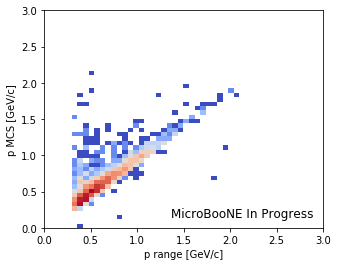

In [107]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 4), sharex=True)

ax.hist2d(
    prange,
    pmcs,
    bins=(50,50),
    range=((0, 3), (0, 3)),
    cmap="coolwarm",
    norm=LogNorm(),
)
ax.set_xlabel("p range [GeV/c]")
ax.set_ylabel("p MCS [GeV/c]")
#plt.title("MicroBooNE In Progress")
ax.text(2.9, 0.1, 'MicroBooNE In Progress', verticalalignment='bottom', horizontalalignment='right', fontsize=12)
#plt.text(x, y, "MicroBooNE In Progress")
#plt.savefig("MCSvsRangeMomentum.png")
plt.show()

### Pseudo-exiting track MCS momentum

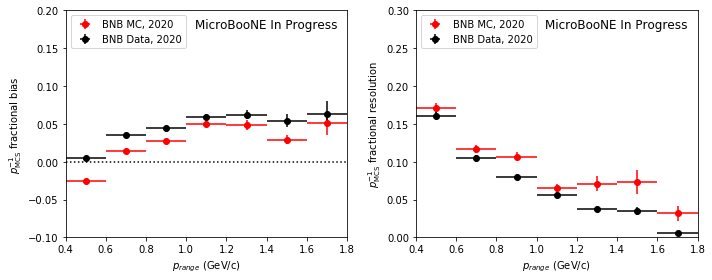

"hitsV cut seems to be crucial for eliminating a strong disagreement in the 0.8-1GeV prange. The track hit cuts don't make a \nbig difference. "

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

xbins = np.linspace(0.4, 1.8, 8)
#8
# Extract a profile histogram
def get_profile(sample):
    #  Selected contained muon candidate tracks
    #muon_candidate & python_select
    df = d[sample]['df_daughters'].query("track_length>100 & contained & muon_candidate  & mcs_trackMomErr_MuFwd_rm10 <7.5 & (mcs_trackMom_MuFwd_rm10 - track_range_mom_mu > -0.2)&\
                                        tk_nhits>30 & tk1_nhits>10 & tk2_nhits>10 &hitsV >150")
    #& hitsU > 150 & hitsV > 150 & hitsY > 150 & track_mcs_ll < 300 & mcs_trackMomErr_MuFwd_rm10 <7.5 & 
    #(mcs_trackMom_MuFwd_rm10 - track_range_mom_mu > -0.2)
    #& tk_nhits>30 & tk1_nhits>10 & tk2_nhits>10 & tk_contain == 0 & vx_ntks<3 &\
                                          #track_length>100
    
    # MCS momentum, whichever of forwards and backwards fit is  best
    pmcs = df.mcs_trackMom_MuFwd_rm10.where(df.mcs_trackIsBestFwd_Mu_rm10==1, df.mcs_trackMom_MuBwd_rm10)
    
    # Range-based momentum
    prange = df.track_range_mom_mu
    
    flag = True
    
    x = xbins[:-1] + np.diff(xbins) / 2
    y = np.empty(shape=len(xbins)-1)
    ye = np.empty_like(y)
    res = np.empty_like(y)
    rese = np.empty_like(y)\

    # Loop over momentum bins
    for i in range(len(xbins)-1):
        # Select tracks in this bin
        selection = np.where((prange >= xbins[i]) & (prange < xbins[i+1]) & (pmcs>0))
        mcs = pmcs.values[selection]
        rng = prange.values[selection]
        
        # Fractional bias mean
        delta = (1.0 / mcs - 1.0 / rng) / (1.0 / rng)
        #if(xbins[i] == 1.4):
            #for j in range(len(specificxbins)-1):
             #   selection = np.where((prange >= specificxbins[j]) & (prange < specificxbins[j+1]) & (pmcs>0))
              #  mcs = pmcs.values[selection]
              #  rng = prange.values[selection]
        
              #  if(np.mean((1.0 / mcs - 1.0 / rng) / (1.0 / rng))>0.14): 
               #     flag = False
                #    continue 
               # beta = (1.0 / mcs - 1.0 / rng) / (1.0 / rng)
               
        if(flag==False):
            flag = True
            y[i] = np.mean(beta)
            ye[i] = np.mean(beta) * np.sqrt(len(mcs)-1) / (len(mcs)-1)  

            res[i] = np.std(beta)
            rese[i] = np.std(beta) * np.sqrt(len(mcs)-1) / (len(mcs)-1)
            continue
                
        y[i] = np.mean(delta)
        ye[i] = np.mean(delta) * np.sqrt(len(mcs)) / len(mcs)  # sqrt(N) errors?

        # Fractional bias width
        res[i] = np.std(delta)
        rese[i] = np.std(delta) * np.sqrt(len(mcs)) / len(mcs)

    return x, y, ye, res, rese

profiles = [
    ('BNB MC, 2020',   'red',   get_profile('nu')),
    ('BNB Data, 2020', 'black', get_profile('on')),
]

for name, color, (x, y, ye, res, rese) in profiles:
    ax1.errorbar(x, y, ye, np.diff(xbins)/2, 'o', color=color, label=name)
    ax2.errorbar(x, res, rese, np.diff(xbins)/2, 'o', color=color, label=name)

    
ax1.set_xlabel(r'$p_{range}$ (GeV/c)')
ax1.set_xlim(xbins[0], xbins[-1])
ax1.set_ylim(-0.1, 0.2)
ax1.set_ylabel(r'$p^{-1}_\mathrm{MCS}$ fractional bias')
ax1.axhline(0, ls='dotted', c='black')
ax1.legend(loc='upper left')
#ax1.set_title("MicroBooNE In Progress")
ax1.text(1.75, 0.19, 'MicroBooNE In Progress', verticalalignment='top', horizontalalignment='right', fontsize=12)

ax2.set_xlabel(r'$p_{range}$ (GeV/c)')
ax2.set_xlim(xbins[0], xbins[-1])
ax2.set_ylim(0, 0.3)
ax2.set_ylabel(r'$p^{-1}_\mathrm{MCS}$ fractional resolution') #it was bias previously but this makes more sense
ax2.legend(loc='upper left')
#ax2.set_title("MicroBooNE In Progress")
ax2.text(1.75, 0.29, 'MicroBooNE In Progress', verticalalignment='top', horizontalalignment='right', fontsize=12)


plt.tight_layout()
#plt.savefig("FractionalBiasResoVsPRange.png")
plt.show()

"""hitsV cut seems to be crucial for eliminating a strong disagreement in the 0.8-1GeV prange. The track hit cuts don't make a 
big difference. """

0.0
250.0
500.0
750.0


ValueError: max must be larger than min in range parameter.

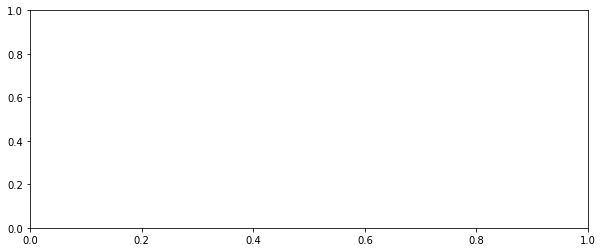

In [66]:
fig, (ax1) = plt.subplots(1, figsize=(10,4))
xbins = np.linspace(0, 1000, 5)
df = d["nu"]['df_daughters'].query('python_select & muon_candidate ')
tk1_nhits = df.tk1_nhits
tk2_nhits = df.tk2_nhits

for i in range(len(xbins)-1):
    selection = np.where((prange >= xbins[i]) & (prange < xbins[i+1]) & (pmcs>0))
    mcs = pmcs.values[selection]
    rng = prange.values[selection]
    print(xbins[i])
    if(np.mean((1.0 / mcs - 1.0 / rng) / (1.0 / rng)) > 0.14): 
        print(pmcs.values[selection])
        print(rng)
    delta = (1.0 / mcs - 1.0 / rng) / (1.0 / rng) 
        
    y[i] = np.mean(delta)
ax1.hist(
       y,
)

plt.show()

### Split tracks

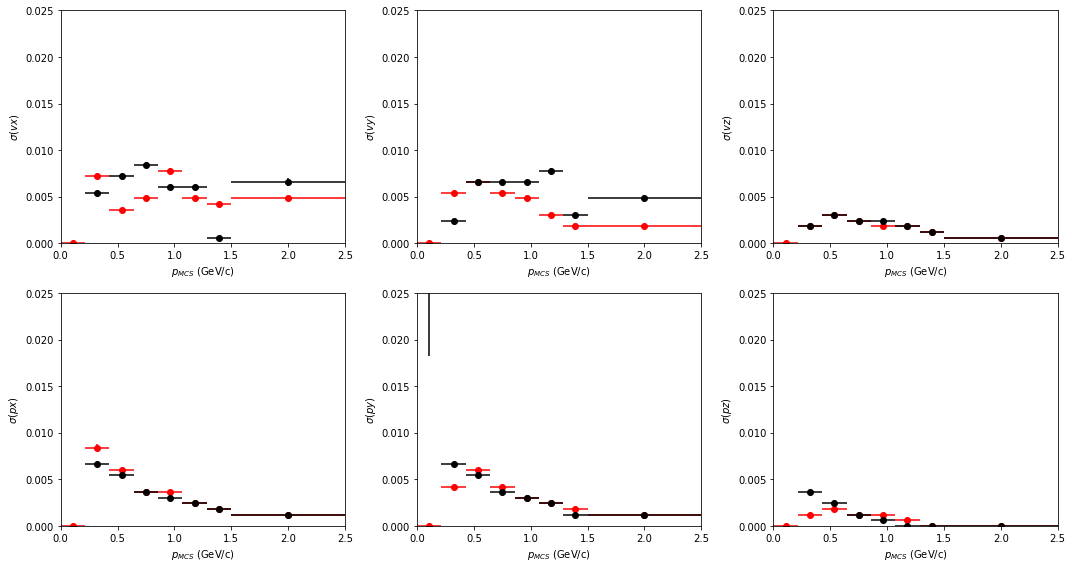

In [109]:
fig, ax = plt.subplots(2, 3, figsize=(15,8))

xbins = np.hstack((np.linspace(0, 1.5, 8), [2.5]))

#& track_mcs_ll < 300 & vz > 100 & nu_score > 0.5 
#& track_diry < 0.4 & track_diry > -0.4
#& strk_mid_gpar_vz > 100
# Selected muon candidate tracks in overlay and data
#contained was removed and the figures look MUCH better
#python_select & muon_candidate query('')
"""track_score>0.90 &\vtx_distance<4.0 &\
                  track_chi2_proton>60.0 &\
                  track_chi2_muon<30.0 &\
                  (track_chi2_proton/track_chi2_muon)>7.0 &\
                  nu_score>0.4"""

df_nu = d['nu']['df_daughters'].query('muon_candidate & python_select & hitsV > 100 & track_length>100 & tk_nhits>30 & tk1_nhits>10 & tk2_nhits>10')
pmcs = df_nu.mcs_trackMom_MuFwd_rm10.where(df_nu.mcs_trackIsBestFwd_Mu_rm10==1, df_nu.mcs_trackMom_MuBwd_rm10)
#pmcs = df.track_range_mom_mu
g1 = df_nu.strk_tk1_gpar_vx

test = d['on']['df_daughters'].strk_tk1_gpar_vy

dfd = d['on']['df_daughters'].query('muon_candidate & python_select & hitsV > 100 & track_length> 100 & tk_nhits>30 & tk1_nhits>10 & tk2_nhits>10')
pmcsd = dfd.mcs_trackMom_MuFwd_rm10.where(dfd.mcs_trackIsBestFwd_Mu_rm10==1, dfd.mcs_trackMom_MuBwd_rm10)
#pmcsd = dfd.track_range_mom_mu
g1d = dfd.strk_tk1_gpar_vx

# Loop over track fit parameters
for i, var in enumerate(('v', 'p')):
    for j, dim in enumerate(('x',  'y', 'z')):
        
        axis = ax[i,j]
        v1 = 'strk_tk1_gpar_%s%s' % (var, dim)
        v2 = 'strk_tk2_gpar_%s%s' % (var, dim)

        x = xbins[:-1] + np.diff(xbins) / 2
        y1 = np.zeros(shape=len(xbins)-1)
        y1e = np.zeros_like(y1)
        y2 = np.zeros(shape=len(xbins)-1)
        y2e = np.zeros_like(y2)
     
        for k in range(len(xbins)-1):
            
            selection = (pmcs >= xbins[k]) & (pmcs < xbins[k+1])
            #& (g1 != 0)
            
           
            selectiond = (pmcsd >= xbins[k]) & (pmcsd < xbins[k+1])
            #& (g1d != 0)
            
     
            # Difference in this parameter
            delta = df_nu[v1][selection] - df_nu[v2][selection]
            
            # The shape is not Gaussian and has a long tail, so the variance is large.
            # To control that, using the full width at half maximum; should confirm
            # what was done in MCC8 studies.
            tbins=np.linspace(-1, 1, 1001)
            hist, _ = np.histogram(delta, bins=tbins)
            br = tbins[np.where(hist>np.max(hist)/2)]
            fwhm = np.max(br)-np.min(br)
            
            y1[k] = fwhm / 2.355 / np.sqrt(2)
            y1e[k] = y1[k] * np.sqrt(np.sum(selection)) / np.sum(selection)

            delta = dfd[v1][selectiond] - dfd[v2][selectiond]

            hist, _ = np.histogram(delta, bins=tbins)
            br = tbins[np.where(hist>np.max(hist)/2)]
            fwhm = np.max(br)-np.min(br)
            y2[k] = fwhm / 2.355 / np.sqrt(2)
            
            y2e[k] = y2[k] * np.sqrt(np.sum(selectiond)) / np.sum(selectiond)
            
            
        
        
        axis.errorbar(x, y1, y1e, np.diff(xbins)/2, 'o', color='red', label='mc')
        
        axis.errorbar(x, y2, y2e, np.diff(xbins)/2, 'o', color='black', label='data')
        
        axis.set_xlabel(r'$p_{MCS}$ (GeV/c)')
        axis.set_ylabel(r'$\sigma(%s%s)$' % (var, dim))
        axis.set_xlim(xbins[0], xbins[-1])
        axis.set_ylim(0, 0.025)
        


plt.tight_layout()
#plt.text(x, y, "MicroBooNE In Progress")
plt.show()

In [55]:
dfs = d['on']['df_daughters']
dftrack = dfs.query('tk1_nhits>0 & tk2_nhits>0 & tk_nhits>0& nu_score > 0.4')

dftrack1 = dftrack.tk1_nhits 
dftrack2 = dftrack.tk2_nhits 
dftrack_total = dftrack.tk_nhits 

dftrack_bool = dftrack1+dftrack2-dftrack_total 

if dftrack_bool.item(0):
    print(dftrack_bool)
    print(len(dftrack_bool))

TypeError: item() takes exactly 1 argument (2 given)

ValueError: zero-size array to reduction operation maximum which has no identity

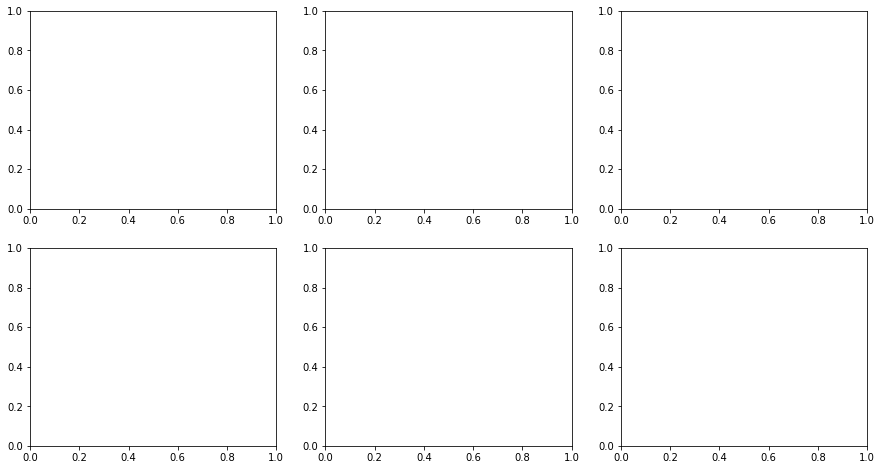

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(15,8))

xbins = np.hstack((np.linspace(0, 1.5, 7), [2.5]))

# Selected muon candidate tracks in overlay and data
df = d['nu']['df_daughters'].query('python_select & muon_candidate & contained')
pmcs = df.mcs_trackMom_MuFwd_rm10.where(df.mcs_trackIsBestFwd_Mu_rm10==1, df.mcs_trackMom_MuBwd_rm10)
g1 = df.strk_tk1_gpar_vx

dfd = d['on']['df_daughters'].query('python_select & muon_candidate & contained')
pmcsd = dfd.mcs_trackMom_MuFwd_rm10.where(dfd.mcs_trackIsBestFwd_Mu_rm10==1, dfd.mcs_trackMom_MuBwd_rm10)
g1d = df.strk_tk1_gpar_vx

# Loop over track fit parameters
for i, var in enumerate(('v', 'p')):
    for j, dim in enumerate(('x',  'y', 'z')):
        axis = ax[i,j]
        v1 = 'strk_tk1_gpar_%s%s' % (var, dim)
        v2 = 'strk_tk2_gpar_%s%s' % (var, dim)

        x = xbins[:-1] + np.diff(xbins) / 2
        y1 = np.zeros(shape=len(xbins)-1)
        y1e = np.zeros_like(y1)
        y2 = np.zeros(shape=len(xbins)-1)
        y2e = np.zeros_like(y2)

        for k in range(len(xbins)-1):
            selection = (pmcs >= xbins[k]) & (pmcs < xbins[k+1]) & (g1 != 0)
            selectiond = (pmcsd >= xbins[k]) & (pmcsd < xbins[k+1]) & (g1d != 0)

            # Difference in this parameter
            delta = df[v1][selection] - df[v2][selection]

            # The shape is not Gaussian and has a long tail, so the variance is large.
            # To control that, using the full width at half maximum; should confirm
            # what was done in MCC8 studies.
            tbins=np.linspace(-1, 1, 1001)
            hist, _ = np.histogram(delta, bins=tbins)
            br = tbins[np.where(hist>np.max(hist)/2)]
            fwhm = np.max(br)-np.min(br)
            
            y1[k] = fwhm / 2.355 / np.sqrt(2)
            y1e[k] = y1[k] * np.sqrt(np.sum(selection)) / np.sum(selection)

            delta = dfd[v1][selectiond] - dfd[v2][selectiond]

            hist, _ = np.histogram(delta, bins=tbins)
            br = tbins[np.where(hist>np.max(hist)/2)]
            fwhm = np.max(br)-np.min(br)
            y2[k] = fwhm / 2.355 / np.sqrt(2)

            y2e[k] = y2[k] * np.sqrt(np.sum(selectiond)) / np.sum(selectiond)

        axis.errorbar(x, y1, y1e, np.diff(xbins)/2, 'o', color='red', label='mc')
        axis.errorbar(x, y2, y2e, np.diff(xbins)/2, 'o', color='black', label='data')

        axis.set_xlabel(r'$p_{MCS}$ (GeV/c)')
        axis.set_ylabel(r'$\sigma(%s%s)$' % (var, dim))
        axis.set_xlim(xbins[0], xbins[-1])
        axis.set_ylim(0, 0.025)
    
plt.tight_layout()
plt.show()


### Split vertex

In [110]:
from scipy.optimize import curve_fit

In [111]:
import lmfit

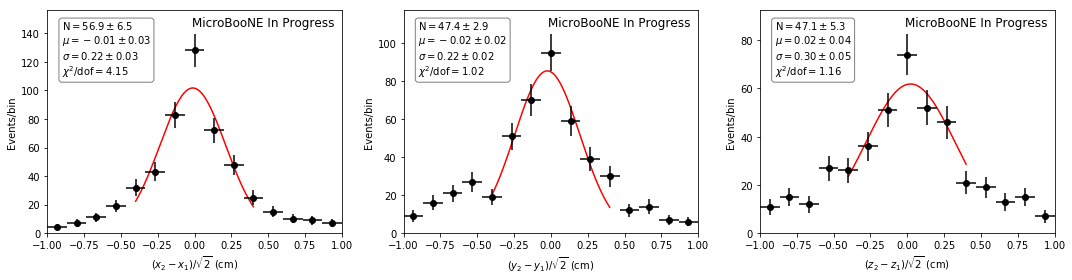

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))

xbins = np.linspace(-1, 1, 16)

# Extract event-level variables of interest
v = ['v%i%spos' % (i,j) for i in [1,2] for j in 'xyz']
ds = d['on']['events'].pandas.df(v + ['num_tracks','nu_mu_cc_selected','nu_score'])
ds = ds[(ds.num_tracks>=4)&(ds.nu_mu_cc_selected)&(ds.v1xpos!=0)&(ds.v2xpos!=0)&(ds.nu_score>0.5)]

# Loop over x, y, z
for i, dim in enumerate('xyz'):
    v1, v2 = 'v1%spos' % dim, 'v2%spos' % dim

    # Histogram the difference / sqrt(2)
    delta = (ds[v1]-ds[v2])  / np.sqrt(2)
    y, _ = np.histogram(delta, bins=xbins)
    ye = np.sqrt(y)
    x = xbins[:-1] + np.diff(xbins)/2
    xe = np.diff(xbins)/2

    ax[i].errorbar(x, y, ye, xe, fmt='o', color='black')
    ax[i].set_xlabel(r'$(%s_2-%s_1)/\sqrt{2}$ (cm)' % (dim, dim))
    ax[i].set_ylabel('Events/bin')

    ax[i].set_xlim(-1,1)

    # Fit a Gaussian
    par = lmfit.Parameters()
    par.add('center', value=0)
    par.add('amplitude', value=np.max(y))
    par.add('sigma', value=0.2)

    def residual(pars, x, data=None, err=None):
        a, mu, std = pars['amplitude'], pars['center'], pars['sigma']
        resids = data - a * scipy.stats.norm.pdf(x, mu, std)
        return np.sqrt(np.square(resids) / np.square(err))

    fit = lmfit.minimize(residual, par, args=(x[4:-5],), kws={'data': y[4:-5], 'err': ye[4:-5]})
    
    xbins2 = np.linspace(x[4],x[-5],1001)
    x2 = xbins2[:-1] + np.diff(xbins2)/2
    a, mu, std = fit.params['amplitude'], fit.params['center'], fit.params['sigma']
    ax[i].plot(x2, a*scipy.stats.norm.pdf(x2, mu, std), c='r', zorder=-100)
    
    err_mu, err_amp, err_std = np.sqrt(np.diag(fit.covar))
    
    textstr = '\n'.join((
    r'$\mathrm{N}=%1.1f\pm%1.1f$' % (fit.params['amplitude'], err_amp),
    r'$\mu=%1.2f\pm%1.2f$' % (fit.params['center'], err_mu),
    r'$\sigma=%1.2f\pm%1.2f$' % (fit.params['sigma'], err_std),
    r'$\chi^2/\mathrm{dof}=%1.2f$' % (fit.redchi)))
   
    props = dict(boxstyle='round',facecolor = 'white', alpha=0.5)

    ax[i].text(0.05, 0.95, textstr, transform=ax[i].transAxes, fontsize=10,
    verticalalignment='top', bbox=props)
    # The parameters should go in a text box on the plot
    #print(dim, pars)
    
    ymax = ax[i].get_ylim()[1]
    ax[i].set_ylim(0, ymax*1.07)
    ax[i].text(0.95, ymax*1.04, 'MicroBooNE In Progress', verticalalignment='top', horizontalalignment='right', fontsize=12)


plt.tight_layout()
#plt.savefig("BNBsplitvertex.png")
plt.show()

In [73]:
d['nu']['daughters'].keys()

['event',
 'run',
 'subrun',
 'evt_time_sec',
 'evt_time_nsec',
 'hitsU',
 'hitsV',
 'hitsY',
 'caloU',
 'caloV',
 'caloY',
 'hitsSps',
 'generation',
 'track_score',
 'is_shower',
 'is_track',
 'has_shower_daughter',
 'is_track_daughter',
 'vx',
 'vy',
 'vz',
 'start_contained',
 'vtx_distance',
 'track_length',
 'track_endx',
 'track_endy',
 'track_endz',
 'track_dirx',
 'track_diry',
 'track_dirz',
 'track_is_muon_candidate',
 'track_range_mom_p',
 'track_range_mom_mu',
 'track_mcs_mom',
 'track_mcs_err',
 'track_mcs_ll',
 'track_chi2_proton',
 'track_chi2_muon',
 'mcs_trackLength_rm10',
 'mcs_trackMom_MuFwd_rm10',
 'mcs_trackMomErr_MuFwd_rm10',
 'mcs_trackLL_MuFwd_rm10',
 'mcs_trackMom_MuBwd_rm10',
 'mcs_trackMomErr_MuBwd_rm10',
 'mcs_trackLL_MuBwd_rm10',
 'mcs_trackMom_Mu_rm10',
 'mcs_trackMomErr_Mu_rm10',
 'mcs_trackLL_Mu_rm10',
 'mcs_trackDeltaLL_Mu_rm10',
 'mcs_trackIsBestFwd_Mu_rm10',
 'strk_mid_gpar',
 'strk_tk1_gpar',
 'strk_tk2_gpar',
 'shower_length',
 'shower_openangle',


In [77]:
contained & hitsU > 150 & hitsV > 150 & hitsY > 150 & track_mcs_ll < 300

NameError: name 'contained' is not defined

0
1
2


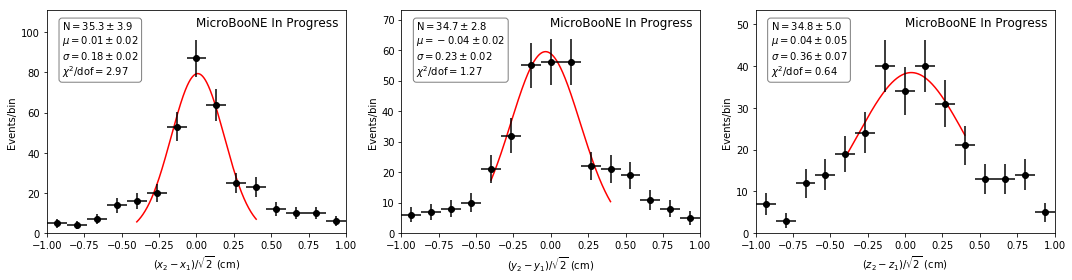

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))

xbins = np.linspace(-1, 1, 16)

# Extract event-level variables of interest
v = ['v%i%spos' % (i,j) for i in [1,2] for j in 'xyz']
ds = d['nu']['events'].pandas.df(v + ['num_tracks','nu_mu_cc_selected','nu_score','nu_contained','hitsU','hitsV','hitsY', 'total_hits'])
ds = ds.query('num_tracks>=4 & nu_mu_cc_selected & v1xpos!=0 & v2xpos != 0 & nu_score>0.5')
#& v1xpos!=0 & v2xpos != 0 & nu_score>0.5 & nu_contained & hitsU>150 & hitsV>150 &hitsY>150

# Loop over x, y, z
for i, dim in enumerate('xyz'):
    print(i)
    v1, v2 = 'v1%spos' % dim, 'v2%spos' % dim

    # Histogram the difference / sqrt(2)
    delta = (ds[v1]-ds[v2])  / np.sqrt(2)
    y, _ = np.histogram(delta, bins=xbins)
    ye = np.sqrt(y)
    x = xbins[:-1] + np.diff(xbins)/2
    xe = np.diff(xbins)/2

    ax[i].errorbar(x, y, ye, xe, fmt='o', color='black')
    ax[i].set_xlabel(r'$(%s_2-%s_1)/\sqrt{2}$ (cm)' % (dim, dim))
    ax[i].set_ylabel('Events/bin')
    #ax[i].set_title("MicroBooNE In Progress")

    # Fit a Gaussian
    par = lmfit.Parameters()
    par.add('center', value=0)
    par.add('amplitude', value=np.max(y))
    par.add('sigma', value=0.2)

    def residual(pars, x, data=None, err=None):
        a, mu, std = pars['amplitude'], pars['center'], pars['sigma']
        resids = data - a * scipy.stats.norm.pdf(x, mu, std)
        return np.sqrt(np.square(resids) / np.square(err))

    fit = lmfit.minimize(residual, par, args=(x[4:-5],), kws={'data': y[4:-5], 'err': ye[4:-5]})
    
    xbins2 = np.linspace(x[4],x[-5],1001)
    x2 = xbins2[:-1] + np.diff(xbins2)/2
    a, mu, std = fit.params['amplitude'], fit.params['center'], fit.params['sigma']
    ax[i].plot(x2, a*scipy.stats.norm.pdf(x2, mu, std), c='r', zorder=-100)
    
    err_mu, err_amp, err_std = np.sqrt(np.diag(fit.covar))
    textstr = '\n'.join((
    r'$\mathrm{N}=%1.1f\pm%1.1f$' % (fit.params['amplitude'], err_amp),
    r'$\mu=%1.2f\pm%1.2f$' % (fit.params['center'], err_mu),
    r'$\sigma=%1.2f\pm%1.2f$' % (fit.params['sigma'], err_std),
    r'$\chi^2/\mathrm{dof}=%1.2f$' % (fit.redchi)))
    
    
    props = dict(boxstyle='round',facecolor = 'white', alpha=0.5)

    ax[i].text(0.05, 0.95, textstr, transform=ax[i].transAxes, fontsize=10,
    verticalalignment='top', bbox=props)
    # The parameters should go in a text box on the plot
    #print(dim, pars)
    
    ax[i].set_xlim(-1,1)
    ymax = ax[i].get_ylim()[1]
    ax[i].set_ylim(0, ymax*1.1)
    ax[i].text(0.95, ymax*1.07, 'MicroBooNE In Progress', verticalalignment='top', horizontalalignment='right', fontsize=12)


plt.tight_layout()
#plt.savefig("overlaysplitvertex.png")
plt.show()

In [ ]:
dk = d['on']['df_daughters'].query('python_select & muon_candidate & contained & track_range_mom_mu > 1.52')
prange = dk.track_range_mom_mu
pmcs = dk.mcs_trackMom_MuFwd_rm10.where(dk.mcs_trackIsBestFwd_Mu_rm10==1, dk.mcs_trackMom_MuBwd_rm10)
phitsY = dk.track_mcs_ll.where(dk.mcs_trackIsBestFwd_Mu_rm10==1, dk.mcs_trackMom_MuBwd_rm10)
ptrackscore= dk.track_score.where(dk.mcs_trackIsBestFwd_Mu_rm10==1, dk.mcs_trackMom_MuBwd_rm10)

print("Items of notice are: 21 and 32")
for i,h in enumerate(phitsY): 
    h = str(h)
    i = str(i)
    print(i + " " + h)
        


In [ ]:
"python_select =   nu_pdg==14 &\
                   nu_contained &\
                   daughters_start_contained &\
                   longest_muon_candidate_length==track_length &\
                   nu_score>0.4 &\
                   track_length>20"

"muon_candidate =  track_score>0.90 &\
                   vtx_distance<4.0 &\
                   track_chi2_proton>60.0 &\
                   track_chi2_muon<30.0 &\
                   (track_chi2_proton/track_chi2_muon)>7.0 &\
                   generation==2 &\
                   track_length>20" 

"contained = track_start_contained and end"

"GIUSUEPPE CUTS = tk_nhits>30 &\
                  tk1_nhits>10 &\ 
                  tk2_nhits>10 &\ 
                  tk_contain == 0 &\ 
                  vx_ntks>2
                  "